In [0]:
displayHTML('''
<center><br> <img src="https://upload.wikimedia.org/wikipedia/commons/0/06/Amazon_2024.svg" style="width: 200px;"></center><br>
''')

In [0]:
displayHTML('''
<div style="display: flex; align-items: center; justify-content: center; flex-wrap: wrap;">
    <div style="flex: 1; max-width: 400px; display: flex; justify-content: center;">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" style="max-width: 50%; height: auto; margin-top: 50px; margin-bottom: 50px;margin-left: 6rem;">
    </div>
    <div style="flex: 2; text-align: center; margin-top: 20px;margin-left: 8rem;">
        <div style="font-size: 28px; font-weight: bold; line-height: 1.2;">
            <span style="color: #d9345b;">BDA Project |</span> <span style="color: #2a2a83;">Sentiment Analysis on Amazon Reviews of Electronics</span>
        </div>
        <div style="font-size: 17px; font-weight: bold; margin-top: 10px;">
            Spring Semester | 2024 - 2025
        </div>
        <div style="font-size: 17px; font-weight: bold;">
            Master in Data Science and Advanced Analytics
        </div>
        <div style="margin-top: 20px;">
            <div>André Silvestre, 20240502</div>
            <div>Filipa Pereira, 20240509</div>
            <div>João Henriques, 20240499</div>
            <div>Umeima Mahomed, 20240543</div>
        </div>
        <div style="margin-top: 20px; font-weight: bold;">
            Group 37
        </div>
    </div>
</div>
''')

BDA Project | Sentiment Analysis on Amazon Reviews of Electronics 
 
 
 Spring Semester | 2024 - 2025
 
 
 Master in Data Science and Advanced Analytics
 
 
 André Silvestre, 20240502 
 Filipa Pereira, 20240509 
 João Henriques, 20240499 
 Umeima Mahomed, 20240543 
 
 
 Group 37

<div style="background: linear-gradient(to right, #f79a06, #d9345b, #113d7c, #3d1c87);
            padding: 7px; color: white; border-radius: 500px; text-align: center;">
</div>

### **PySpark Session**

In [0]:
from pyspark.sql import SparkSession

# Initialize Spark Session with optimized configurations
# Source: https://spark.apache.org/docs/latest/configuration.html
spark = (SparkSession.builder
         .appName("AmazonReviewsBigDataAnalytics_ResultsAnalysis")
         .config("spark.driver.memory", "15g")              # Adjust memory for driver
         .config("spark.executor.memory", "15g")            # Adjust memory per executor
         .getOrCreate())

# Set Spark configurations for convert to Pandas without errors
# Source: https://stackoverflow.com/questions/47536123/collect-or-topandas-on-a-large-dataframe-in-pyspark-emr
#         https://stackoverflow.com/questions/50958721/convert-a-spark-dataframe-to-pandas-df
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

## 📚 **Libraries Import**

In [0]:
# Imports for System Operations
import os
import sys
import time
import datetime

# Imports for Data Manipulation
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Imports for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

# Imports PySpark
from pyspark.sql.types import *
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark.sql.functions import when, col

---

## 🧮 **Import Databases**

### **🟥 Databricks FileStore**

- If you are using Databricks, you can just use the following code to import the dataset:
    - Otherwise, you replace **`%sh`** with **`!`** and run the command in your terminal. Don't forget to replace the path with your local path.


In [0]:
%sh
# Create the directory for the dataset
mkdir -p /databricks/driver/AmazonReviews_Results

# Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# Step 1: Fetch the confirmation token and save cookies (Reviews)
wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
  "https://drive.usercontent.google.com/download?id=1LzVB9qn7VSMrkYS4nzCqJN2TROBvsKQP&export=download" -O- | \
  sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# Step 2: Read the confirmation token
confirm_token=$(cat /tmp/confirm.txt)

# Step 3: Download the file using the confirmation token and cookies, with the desired filename (Reviews)
wget --load-cookies /tmp/cookies.txt \
  "https://drive.usercontent.google.com/download?id=1LzVB9qn7VSMrkYS4nzCqJN2TROBvsKQP&export=download&confirm=$confirm_token" \
  -O /databricks/driver/AmazonReviews_Results/df-computers-reviews-results.zip

# Step 4: Clean up temporary files
rm /tmp/cookies.txt /tmp/confirm.txt

--2025-05-16 14:25:26--  https://drive.usercontent.google.com/download?id=1LzVB9qn7VSMrkYS4nzCqJN2TROBvsKQP&export=download&confirm=
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.217.65, 2607:f8b0:400a:80a::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.217.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 189639092 (181M) [application/octet-stream]
Saving to: ‘/databricks/driver/AmazonReviews_Results/df-computers-reviews-results.zip’

     0K .......... .......... .......... .......... ..........  0% 3.62M 50s
    50K .......... .......... .......... .......... ..........  0% 7.30M 37s
   100K .......... .......... .......... .......... ..........  0% 6.32M 34s
   150K .......... .......... .......... .......... ..........  0% 9.66M 30s
   200K .......... .......... .......... .......... ..........  0% 7.53M 29s
   250K .......... .......... .......... .......... ..........  0% 10.9M 

In [0]:
%sh
# Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# Step 1: Fetch the confirmation token and save cookies (Products)
wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
  "https://drive.usercontent.google.com/download?id=1LzY8cFBF6n7iZWP46Cu44H_kPIpYGIDM&export=download" -O- | \
  sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# Step 2: Read the confirmation token
confirm_token=$(cat /tmp/confirm.txt)

# Step 3: Download the file using the confirmation token and cookies, with the desired filename (Products)
wget --load-cookies /tmp/cookies.txt \
  "https://drive.usercontent.google.com/download?id=1LzY8cFBF6n7iZWP46Cu44H_kPIpYGIDM&export=download&confirm=$confirm_token" \
  -O /databricks/driver/AmazonReviews_Results/df-computers-products-results.zip

# Step 4: Clean up temporary files
rm /tmp/cookies.txt /tmp/confirm.txt

--2025-05-16 14:25:46--  https://drive.usercontent.google.com/download?id=1LzY8cFBF6n7iZWP46Cu44H_kPIpYGIDM&export=download&confirm=
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.217.65, 2607:f8b0:400a:80a::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.217.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5451828 (5.2M) [application/octet-stream]
Saving to: ‘/databricks/driver/AmazonReviews_Results/df-computers-products-results.zip’

     0K .......... .......... .......... .......... ..........  0% 3.11M 2s
    50K .......... .......... .......... .......... ..........  1% 5.24M 1s
   100K .......... .......... .......... .......... ..........  2% 6.57M 1s
   150K .......... .......... .......... .......... ..........  3% 9.29M 1s
   200K .......... .......... .......... .......... ..........  4% 17.0M 1s
   250K .......... .......... .......... .......... ..........  5% 13.6M 1s
   

In [0]:
%sh
# Print the contents of the driver directory
ls -lh /databricks/driver/

total 1.3M
drwxr-xr-x 2 root root 4.0K May 16 14:25 AmazonReviews_Results
drwxr-xr-x 2 root root 4.0K May 16 00:59 azure
drwxr-xr-x 2 root root 4.0K May 16 00:59 conf
drwxr-xr-x 3 root root 4.0K May 16 14:24 eventlogs
-r-xr-xr-x 1 root root 2.7K May 16 00:59 hadoop_accessed_config.lst
drwxr-xr-x 2 root root 4.0K May 16 14:24 logs
-r-xr-xr-x 1 root root 1.3M May 16 00:59 preload_class.lst


In [0]:
%sh
# Unzip the downloaded files
unzip  /databricks/driver/AmazonReviews_Results/df-computers-reviews-results.zip -d  /databricks/driver/AmazonReviews_Results/df-computers-reviews-results
unzip  /databricks/driver/AmazonReviews_Results/df-computers-products-results.zip -d  /databricks/driver/AmazonReviews_Results/df-computers-products-results

# List the unzipped files
ls -lh  /databricks/driver/AmazonReviews_Results/

Archive:  /databricks/driver/AmazonReviews_Results/df-computers-reviews-results.zip
  inflating: /databricks/driver/AmazonReviews_Results/df-computers-reviews-results/reviews_df/reviews_df/part-00004-673a615d-9b38-4d01-a888-442f599b788c-c000.snappy.parquet  
  inflating: /databricks/driver/AmazonReviews_Results/df-computers-reviews-results/reviews_df/reviews_df/part-00005-673a615d-9b38-4d01-a888-442f599b788c-c000.snappy.parquet  
  inflating: /databricks/driver/AmazonReviews_Results/df-computers-reviews-results/reviews_df/reviews_df/part-00003-673a615d-9b38-4d01-a888-442f599b788c-c000.snappy.parquet  
  inflating: /databricks/driver/AmazonReviews_Results/df-computers-reviews-results/reviews_df/reviews_df/part-00000-673a615d-9b38-4d01-a888-442f599b788c-c000.snappy.parquet  
  inflating: /databricks/driver/AmazonReviews_Results/df-computers-reviews-results/reviews_df/reviews_df/.part-00000-673a615d-9b38-4d01-a888-442f599b788c-c000.snappy.parquet.crc  
  inflating: /databricks/driver/Amaz

### **🟨 Google Colab/Locally FileStore**

- If you are using Google Colab or running the notebook locally, you can use the following code to download the dataset.

In [0]:
# # Create a directory for the data
# !mkdir -p /content/AmazonReviews_Results/

In [0]:
# # Download the file from Google Drive using wget
# # Source: https://stackoverflow.com/questions/25010369/wget-curl-large-file-from-google-drive
# # Download the file using the confirmation token and cookies (Reviews)
# !wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
#   "https://drive.usercontent.google.com/download?id=1LzVB9qn7VSMrkYS4nzCqJN2TROBvsKQP&export=download" -O- | \
#   sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# # Read the confirmation token from the temporary file
# with open('/tmp/confirm.txt', 'r') as f:
#     confirm_token = f.read().strip()

# # Download the file using the confirmation token and cookies (Reviews)
# !wget --load-cookies /tmp/cookies.txt \
#   "https://drive.usercontent.google.com/download?id=1LzVB9qn7VSMrkYS4nzCqJN2TROBvsKQP&export=download&confirm={confirm_token}" \
#   -O /content/AmazonReviews_Results/df-computers-reviews-results.zip

# # Clean up temporary files
# !rm /tmp/cookies.txt /tmp/confirm.txt

In [0]:
# # Download the file using the confirmation token and cookies (Products)
# !wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \
#   "https://drive.usercontent.google.com/download?id=1LzY8cFBF6n7iZWP46Cu44H_kPIpYGIDM&export=download" -O- | \
#   sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p' > /tmp/confirm.txt

# # Read the confirmation token from the temporary file
# with open('/tmp/confirm.txt', 'r') as f:
#     confirm_token = f.read().strip()

# # Download the file using the confirmation token and cookies (Products)
# !wget --load-cookies /tmp/cookies.txt \
#   "https://drive.usercontent.google.com/download?id=1LzY8cFBF6n7iZWP46Cu44H_kPIpYGIDM&confirm={confirm_token}" \
#   -O /content/AmazonReviews_Results/df-computers-products-results.zip

# # Clean up temporary files
# !rm /tmp/cookies.txt /tmp/confirm.txt

In [0]:
# # List files in the /content directory to verify the download
# !ls -lh /content/

# # Unzip the downloaded file
# !unzip /content/AmazonReviews_Results/df-computers-reviews-results.zip -d /content/AmazonReviews_Results/df-computers-reviews-results
# !unzip /content/AmazonReviews_Results/df-computers-products-results.zip -d /content/AmazonReviews_Results/df-computers-products-results

# # List the unzipped files to verify
# !ls -lh /content/AmazonReviews_Results/

---

### **🧮 PySpark Load Data**

In [0]:

# Import Data (Products and Reviews from Amazon since 2022 - Electronics.Computers | After Preprocessing)

# Read the reviews DataFrame
# reviews_df = spark.read.parquet("./data/AmazonReviews_Results/df-computers-reviews-results/reviews_df/reviews_df")                 # Local Path
reviews_df = spark.read.parquet("file:/databricks/driver/AmazonReviews_Results/df-computers-reviews-results/reviews_df/reviews_df")  # Databricks Path
# reviews_df = spark.read.parquet("/content/AmazonReviews_Results/df-computers-reviews-results/reviews_df/reviews_df")               # Google Colab Path

# Read the products/metadata DataFrame
# products_df = spark.read.parquet("./data/AmazonReviews_Results/df-computers-products-results/products_df/products_df")                 # Local Path
products_df = spark.read.parquet("file:/databricks/driver/AmazonReviews_Results/df-computers-products-results/products_df/products_df")  # Databricks Path
# products_df = spark.read.parquet("/content/AmazonReviews_Results/df-computers-products-results/products_df/products_df")               # Google Colab Path

### **Reviews**

In [0]:
# Verification of the first observation and schema (Reviews)
reviews_df.printSchema()
reviews_df.show(1, vertical=True)

# Number of Observations and Features
print("\n\033[1mNumber of Observations:\033[0m ", reviews_df.count())
print("\033[1mNumber of Features:\033[0m ", len(reviews_df.columns))

root
 |-- review_id: integer (nullable = true)
 |-- review_text: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- helpful_vote: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- timestamp_dt: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- TXRBSF_SentimentLabel: string (nullable = true)
 |-- TXRBSF_SentimentScore: double (nullable = true)
 |-- mDeBERTa_SentimentLabel: string (nullable = true)
 |-- mDeBERTa_SentimentScore: double (nullable = true)

-RECORD 0---------------------------------------
 review_id               | 2                    
 review_text             | Absolutely terrib... 
 parent_asin             | B07B2HX4RG           
 user_id                 | AE3KC3RSMJ6HIYRQC... 
 rating

### **Products/Metadata**

In [0]:
# Verification of the first observation and schema (Products)
products_df.printSchema()
products_df.show(1, vertical=True)

# Number of Observations and Features
print("\n\033[1mNumber of Observations:\033[0m ", products_df.count())
print("\033[1mNumber of Features:\033[0m ", len(products_df.columns))

root
 |-- parent_asin: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- meta_average_rating: double (nullable = true)
 |-- meta_rating_number: integer (nullable = true)
 |-- meta_price: double (nullable = true)
 |-- meta_store: string (nullable = true)
 |-- TopicLabel: string (nullable = true)
 |-- TopicScore: double (nullable = true)

-RECORD 0-----------------------------------
 parent_asin         | 0594149290           
 product_title       | Barnes Noble Nook... 
 meta_average_rating | 4.0                  
 meta_rating_number  | 12                   
 meta_price          | 147.95               
 meta_store          | Barnes & Noble       
 TopicLabel          | Drives and Storage   
 TopicScore          | 0.28259041905403137  
only showing top 1 row


Number of Observations:  59418
Number of Features:  8


## 📋 **Evaluate Data**

### 🔄 **Duplicates**

In [0]:
# Check for duplicates (it is expected to don't have duplicates, since we already removed them in **`./0_DataCollection_BDAProject_Group37_DataBricks.ipynb`**)
print("\n\033[1mNumber of Duplicates in Reviews DataFrame:\033[0m",
      reviews_df.count() - reviews_df.dropDuplicates().count())

print("\n\033[1mNumber of Duplicates in Products DataFrame:\033[0m",
      products_df.count() - products_df.dropDuplicates().count())


Number of Duplicates in Reviews DataFrame: 0

Number of Duplicates in Products DataFrame: 0


### 🔎 **Missing Values and Distinct Values**

In [0]:
# Check missing values and distinct values for reviews_df

# Count the number of distinct values in each column
count_obs = reviews_df.count()

# List to store columns with missing values
missing_values_reviews_df = []

# Define and print the header for the output table
header = "{:<38} | {:<33} | {:<26} | {:<18}".format("\033[1mColumn Name\033[0m", "\033[1mColumn Type\033[0m", "\033[1mEmpty/Null Count\033[0m", "\033[1mPercentage\033[0m")
print(header)
print("-" * len(header)) # Dynamic separator line length

# Iterate through each column structure (name and type) in the DataFrame schema
for col_struct in reviews_df.schema:
    col_name = col_struct.name
    col_type = col_struct.dataType
    col_type_str = str(col_type) # Get a string representation for printing

    # Determine the condition for 'empty/missing' based on the data type
    if isinstance(col_type, StringType):
        # For String columns: check for NULL OR empty string OR whitespace-only string
        # F.trim removes leading/trailing whitespace. If the result is '', it was empty or just whitespace.
        condition = F.col(col_name).isNull() | (F.trim(F.col(col_name)) == '')
        type_desc = "String"

    elif isinstance(col_type, ArrayType):
        # For Array columns (like array<string> or array<struct>): check for NULL OR an empty array (size 0)
        condition = F.col(col_name).isNull() | (F.size(F.col(col_name)) == 0)
        # Make type description more informative for arrays
        type_desc = f"Array({str(col_type.elementType)})"[:25] # Truncate if too long

    else:
        # Default for other types (Numeric, Boolean, BigInt, Struct, etc.): only check for NULL values
        condition = F.col(col_name).isNull()
        type_desc = col_type_str[:25] # Use string representation, truncate if long

    # Count the number of rows where the condition is true for the current column
    empty_count = reviews_df.where(condition).count()

    # Calculate the percentage
    percentage = (empty_count * 100 / count_obs) if count_obs > 0 else 0
    percentage_str = f"{percentage:>9.2f}%"

    # Append the column name and type to the list of missing values
    missing_values_reviews_df.append((col_name, type_desc, empty_count, percentage))

    # Print the results for the current column using f-string formatting
    # \033[1m...\033[0m adds bold formatting for the column name in supporting terminals
    print(f"\033[1m{col_name:<30}\033[0m | {type_desc:<25} | {str(empty_count):<18} | {percentage_str}")

Column Name                    | Column Type               | Empty/Null Count   | Percentage
----------------------------------------------------------------------------------------------------------------------------
review_id                      | IntegerType()             | 0                  |      0.00%
review_text                    | String                    | 452                |      0.04%
parent_asin                    | String                    | 0                  |      0.00%
user_id                        | String                    | 0                  |      0.00%
rating                         | IntegerType()             | 0                  |      0.00%
helpful_vote                   | IntegerType()             | 0                  |      0.00%
timestamp                      | LongType()                | 0                  |      0.00%
timestamp_dt                   | String                    | 0                  |      0.00%
year                           | Integ

In [0]:
# Check missing values and distinct values for products_df

# Count the number of distinct values in each column
count_obs = products_df.count()

# List to store columns with missing values
missing_values_products_df = []

# Define and print the header for the output table
header = "{:<38} | {:<33} | {:<26} | {:<18}".format("\033[1mColumn Name\033[0m", "\033[1mColumn Type\033[0m", "\033[1mEmpty/Null Count\033[0m", "\033[1mPercentage\033[0m")
print(header)
print("-" * len(header)) # Dynamic separator line length

# Iterate through each column structure (name and type) in the DataFrame schema
for col_struct in products_df.schema:
    col_name = col_struct.name
    col_type = col_struct.dataType
    col_type_str = str(col_type) # Get a string representation for printing

    # Determine the condition for 'empty/missing' based on the data type
    if isinstance(col_type, StringType):
        # For String columns: check for NULL OR empty string OR whitespace-only string
        # F.trim removes leading/trailing whitespace. If the result is '', it was empty or just whitespace.
        condition = F.col(col_name).isNull() | (F.trim(F.col(col_name)) == '')
        type_desc = "String"

    elif isinstance(col_type, ArrayType):
        # For Array columns (like array<string> or array<struct>): check for NULL OR an empty array (size 0)
        condition = F.col(col_name).isNull() | (F.size(F.col(col_name)) == 0)
        # Make type description more informative for arrays
        type_desc = f"Array({str(col_type.elementType)})"[:25] # Truncate if too long

    else:
        # Default for other types (Numeric, Boolean, BigInt, Struct, etc.): only check for NULL values
        condition = F.col(col_name).isNull()
        type_desc = col_type_str[:25] # Use string representation, truncate if long

    # Count the number of rows where the condition is true for the current column
    empty_count = products_df.where(condition).count()

    # Calculate the percentage
    percentage = (empty_count * 100 / count_obs) if count_obs > 0 else 0
    percentage_str = f"{percentage:>9.2f}%"

    # Append the column name and type to the list of missing values
    missing_values_products_df.append((col_name, type_desc, empty_count, percentage))

    # Print the results for the current column using f-string formatting
    # \033[1m...\033[0m adds bold formatting for the column name in supporting terminals
    print(f"\033[1m{col_name:<30}\033[0m | {type_desc:<25} | {str(empty_count):<18} | {percentage_str}")

Column Name                    | Column Type               | Empty/Null Count   | Percentage
----------------------------------------------------------------------------------------------------------------------------
parent_asin                    | String                    | 0                  |      0.00%
product_title                  | String                    | 0                  |      0.00%
meta_average_rating            | DoubleType()              | 0                  |      0.00%
meta_rating_number             | IntegerType()             | 0                  |      0.00%
meta_price                     | DoubleType()              | 0                  |      0.00%
meta_store                     | String                    | 13                 |      0.02%
TopicLabel                     | String                    | 0                  |      0.00%
TopicScore                     | DoubleType()              | 0                  |      0.00%


In [0]:
# Check 'None' values in 'TXRBSF_SentimentLabel' column
reviews_df.filter(reviews_df['TXRBSF_SentimentLabel'].isNull()).show(5)

+---------+-----------+-----------+--------------------+------+------------+-------------+-------------------+----+-----+---+-----------+----+---------------------+---------------------+-----------------------+-----------------------+
|review_id|review_text|parent_asin|             user_id|rating|helpful_vote|    timestamp|       timestamp_dt|year|month|day|day_of_week|hour|TXRBSF_SentimentLabel|TXRBSF_SentimentScore|mDeBERTa_SentimentLabel|mDeBERTa_SentimentScore|
+---------+-----------+-----------+--------------------+------+------------+-------------+-------------------+----+-----+---+-----------+----+---------------------+---------------------+-----------------------+-----------------------+
|    17581|           | B0BZ4KFMKC|AH5C7QQROACRAMM5E...|     5|           0|1641612707505|2022-01-08 03:31:47|2022|    1|  8|          7|   3|                 null|                 null|                   null|                   null|
|    18870|           | B0BYSKLWHY|AH2WBQOZ5RCXC6Z4S...|    

- We will drop reviews with missing values in the `reviewText` and `Sentiment` columns.

In [0]:
# Drop reviews with missing values in the `Sentiment` columns
reviews_df = reviews_df.dropna(subset=['TXRBSF_SentimentLabel', 'mDeBERTa_SentimentLabel'])
print("\n\033[1mNumber of Observations after dropping missing values:\033[0m ", reviews_df.count())


Number of Observations after dropping missing values:  1085431


In [0]:
# Summary statistics for numeric columns in reviews_df
print("\n\033[1mSummary Statistics for Numeric Columns in Reviews DataFrame:\033[0m")
reviews_df.describe().display()


Summary Statistics for Numeric Columns in Reviews DataFrame:


summary,review_id,review_text,parent_asin,user_id,rating,helpful_vote,timestamp,timestamp_dt,year,month,day,day_of_week,hour,TXRBSF_SentimentLabel,TXRBSF_SentimentScore,mDeBERTa_SentimentLabel,mDeBERTa_SentimentScore
count,1085431,1085431,1085431,1085431,1085431,1085431,1085431,1085431,1085431,1085431,1085431,1085431,1085431,1085431,1085431,1085431,1085431
mean,542953.1188154751,957.2857142857143,8.214101327725E9,null,4.0004394567687855,0.5971876609383738,1.663264588373647E12,null,2022.2950081580498,5.463627812362094,15.496861615339897,3.988024112080823,13.192795304353755,null,0.8964326823477943,null,0.8734483244103113
stddev,313463.59502982337,1448.5757044174707,3.4314061448610525E9,null,1.5140250968650013,2.964905231573509,1.3220595631858097E10,null,0.4560466383396182,3.487410157274005,8.74839230949241,1.9623252255869725,7.506271082225848,null,0.13031096107086654,null,0.14500417519150918
min,1,10,0594149290,AE22222X4BO3JQVOMEHHRPVRTB6A,1,0,1640995201592,2022-01-01 00:00:01,2022,1,1,1,0,Negative,0.33924585580825806,Negative,0.3348357081413269
max,1085883,zzz xxxxx,B0CKTJCPHQ,AHZZZX5LNNKLAZCTZNB6F445ZIIQ,5,758,1694557332472,2023-09-12 22:22:12,2023,12,31,7,23,Positive,0.9935622215270996,Positive,0.9991295337677002


In [0]:
# Summary statistics for numeric columns in products_df
print("\n\033[1mSummary Statistics for Numeric Columns in Products DataFrame:\033[0m")
products_df.describe().display()


Summary Statistics for Numeric Columns in Products DataFrame:


summary,parent_asin,product_title,meta_average_rating,meta_rating_number,meta_price,meta_store,TopicLabel,TopicScore
count,59418,59418,59418,59418,59418,59405,59418,59418
mean,6.684434032454545E9,null,4.241332592816991,739.6497021104716,157.7389301222264,482.0625,null,0.577029176565103
stddev,4.463087842412544E9,null,0.5716054363669985,4999.221437572963,342.9539320420795,1649.380104514016,null,0.20045638017434117
min,0594149290,5 PACK Bfenown Replacement HDD HARD DRIVE CADDY DOOR COVER WITH HDD SCREWS for DELL LATITUDE E6430 E6530 E6330,1.0,1,0.32,.mem76.,Computer Accessories,0.12186460942029953
max,B0CKTJCPHQ,zzirvepaiv Mechanical Keyboard Keycaps Mahjong Cherry Profile 127 Keys Dye Sub KeyCaps Compatible with Cherry MX GK61 64 84 96DIY Gift for Game Lovers,5.0,402800,9556.21,Ｒ∞ＲａｓＴｅｃｈ,Tablets,0.9893991351127625


In [0]:
displayHTML('''
# <span style="color: #ffffff;">6 | Sentiment and Topic Analysis</span>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: linear-gradient(to right, #f79a06, #d9345b, #113d7c, #3d1c87);
            padding: 10px; color: white; border-radius: 300px; text-align: center;">
    <center><h1 style="margin-top: 10px; margin-bottom: 4px; color: white;
                       font-size: 32px; font-family: 'Avenir Next LT Pro', sans-serif;">
        <b>6 | Sentiment and Topic Analysis</b></h1></center>
</div>

<br>
''')

# 6 | Sentiment and Topic Analysis 
 


 
 
 6 | Sentiment and Topic Analysis

In [0]:
# Color Palette for Data Visualization
color_palette = [
    "#F79A06",  # Vibrant Orange      0
    "#E46D20",  # Burnt Orange        1
    "#D9345B",  # Reddish Pink        2
    "#C32A68",  # Dark Magenta        3
    "#9F1F74",  # Warm Purple         4
    "#731C7E",  # Deep Purple         5
    "#3D1C87",  # Dark Blue-Purple    6
    "#113D7C",  # Intense Blue        7
    "#0C5A9D",  # Vibrant Blue        8
    "#0987C3"   # Light Blue          9
]

# Set the color palette for Seaborn
sns.set_style("white")

---

In [0]:
displayHTML('''
## <span style="color: #ffffff;">Sentiment Analysis</span>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: transparent;
            padding: 10px; color: white; border-radius: 300px; text-align: center;
            border: 2px solid #C32A68;">
    <center><h2 style="margin-left: 120px;margin-top: 10px; margin-bottom: 4px; color: #C32A68;
                       font-size: 34px; font-family: 'Avenir Next LT Pro', sans-serif;"><b>Sentiment Analysis</b></h2></center>
</div>
''')

## Sentiment Analysis 
 


 
 Sentiment Analysis

### **🗨️ Reviews** (review_text)

In [0]:
# Color Palette for Sentiment Analysis
sentiment_colors = {'Positive': '#64C548',
                     'Neutral': '#F47131',
                     'Negative': '#CF213D'}

sentiment_colors_full = {'Positive': '#64C548',
                         'Positive Tendency': '#EBA722',
                         'Neutral': '#F47131',
                         'Negative Tendency': '#F03F42',
                         'Negative': '#CF213D'}

### **🟡 HuggingFace [twitter-xlm-roberta-base-sentiment-finetunned](https://huggingface.co/citizenlab/twitter-xlm-roberta-base-sentiment-finetunned)**

In [0]:
# Count the number of reviews for each sentiment
TXRBSF_sentiment_pd = reviews_df.groupBy("TXRBSF_SentimentLabel") \
    .count() \
    .orderBy("count", ascending=False) \
    .toPandas() # Convert to Pandas DataFrame for visualization

# Absolute and Relative Table of Sentiment Counts
TXRBSF_sentiment_pd['%'] = TXRBSF_sentiment_pd['count'] / TXRBSF_sentiment_pd['count'].sum()                    # Calculate relative counts
TXRBSF_sentiment_pd['%'] = TXRBSF_sentiment_pd['%'].apply(lambda x: f"{x:.2%}")                                 # Format as percentage
TXRBSF_sentiment_pd = TXRBSF_sentiment_pd.rename(columns={"TXRBSF_SentimentLabel": "Sentiment", "count": "n"})  # Rename columns
TXRBSF_sentiment_pd = TXRBSF_sentiment_pd[["Sentiment", "n", "%"]]                                              # Reorder columns
TXRBSF_sentiment_pd = TXRBSF_sentiment_pd.set_index("Sentiment")                                                # Set 'Sentiment' as index
TXRBSF_sentiment_pd

,n,%
Sentiment,,
Positive,530567,48.88%
Neutral,379199,34.94%
Negative,175665,16.18%


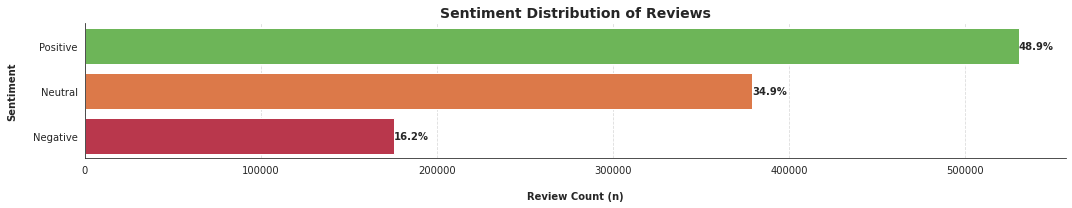

In [0]:
# ============================================
#      Analysis of Sentiment Results
# ============================================
# Count the number of reviews for each sentiment
TXRBSF_sentiment_pd = reviews_df.groupBy("TXRBSF_SentimentLabel") \
    .count() \
    .orderBy(F.desc("count")) \
    .toPandas() # Convert to Pandas for visualization

# Ensure the order matches the color dict if needed for consistency
TXRBSF_sentiment_pd = TXRBSF_sentiment_pd.set_index('TXRBSF_SentimentLabel').reindex(sentiment_colors.keys()).reset_index().fillna(0)

# Plot the sentiment counts
plt.figure(figsize=(15, 3))
sns.barplot(x="count", y="TXRBSF_SentimentLabel", data=TXRBSF_sentiment_pd,
            palette=sentiment_colors, order=sentiment_colors.keys())

plt.title("Sentiment Distribution of Reviews", fontsize=14, fontweight='bold')
plt.xlabel("\nReview Count (n)", fontsize=10, fontweight='bold')
plt.ylabel("Sentiment\n", fontsize=10, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentages on the bars
for index, value in enumerate(TXRBSF_sentiment_pd['count']):
    percentage = (value / TXRBSF_sentiment_pd['count'].sum()) * 100
    plt.text(value + 5, index, f"{percentage:.1f}%", va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
sns.despine(right=True, top=True)
plt.show()

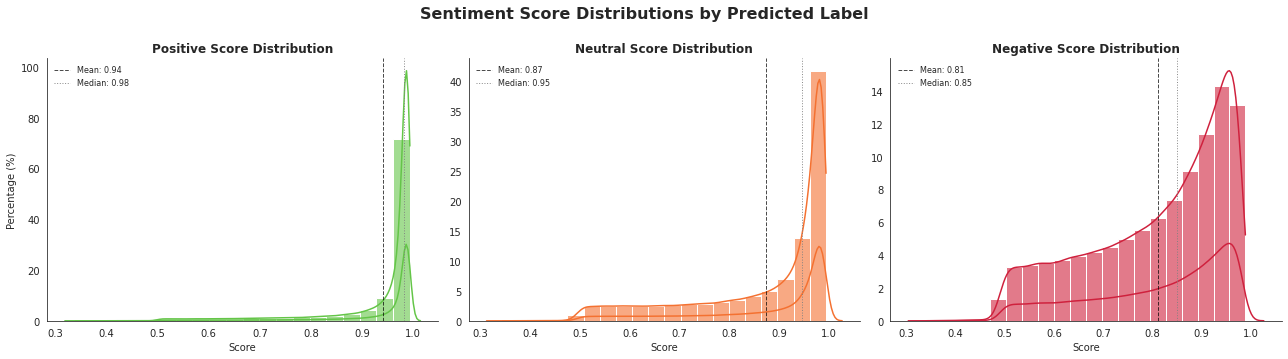

In [0]:
# Plot Score Distribution Histograms/KDE Plots
from math import ceil

# Define number of rows/cols for subplots
n_sentiments = len(sentiment_colors)
n_cols = 3
n_rows = ceil(n_sentiments / n_cols)

fig_hist, axes_hist = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False) # Ensure axes_hist is 2D array
axes_hist = axes_hist.flatten()                                                                     # Flatten for easy iteration
TXRBSF_sentiment_pd = reviews_df.select("TXRBSF_SentimentLabel", "TXRBSF_SentimentScore").toPandas()# Convert to Pandas DataFrame for visualization
plot_idx = 0                                                                                        # Initialize plot index
for sentiment, color in sentiment_colors.items():
    if plot_idx < len(axes_hist):                                                                   # Check if subplot exists
        ax = axes_hist[plot_idx]
        scores = TXRBSF_sentiment_pd[TXRBSF_sentiment_pd["TXRBSF_SentimentLabel"] == sentiment]["TXRBSF_SentimentScore"]

        if not scores.empty:
            sns.histplot(scores, color=color, kde=True, stat='percent', alpha=0.6, ax=ax, bins=20)
            sns.kdeplot(scores, color=color, lw=1.5, warn_singular=False, ax=ax)

            mean_val = scores.mean()
            median_val = scores.median()
            ax.axvline(mean_val, color='black', linestyle='--', linewidth=1, alpha=0.7, label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='grey', linestyle=':', linewidth=1, alpha=0.9, label=f'Median: {median_val:.2f}')

            ax.set_title(f"{sentiment} Score Distribution", fontweight='bold')
            ax.set_xlabel("Score")
            ax.set_ylabel("Percentage (%)" if plot_idx % n_cols == 0 else "") # Y-label only on left
            ax.legend(fontsize=8, frameon=False)
            sns.despine(ax=ax, top=True, right=True)
        else:
            ax.set_title(f"{sentiment} Score Distribution\n(No Data)", fontweight='bold')
            ax.text(0.5, 0.5, "No valid scores found", ha='center', va='center', transform=ax.transAxes)
            ax.set_yticks([])
            ax.set_xticks([])
            sns.despine(ax=ax, left=True, bottom=True, top=True, right=True)

        plot_idx += 1
    else:
        break # Stop if we run out of axes

# Hide any unused subplots
for i in range(plot_idx, len(axes_hist)):
    axes_hist[i].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])                                                                   # Adjust layout to prevent title overlap
plt.suptitle("Sentiment Score Distributions by Predicted Label", fontsize=16, fontweight='bold', y=1.02)    # Add a title above all subplots
plt.show()                                                                                                  # Show the plot

---

### 🟡 **HuggingFace [mDeBERTa-v3-base-xnli-multilingual-nli-2mil7](https://huggingface.co/MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7)**

In [0]:
# Count the number of reviews for each sentiment
mDeBERTa_sentiment_pd = reviews_df.groupBy("mDeBERTa_SentimentLabel") \
    .count() \
    .orderBy("count", ascending=False) \
    .toPandas() # Convert to Pandas DataFrame for visualization

# Absolute and Relative Table of Sentiment Counts
mDeBERTa_sentiment_pd['%'] = mDeBERTa_sentiment_pd['count'] / mDeBERTa_sentiment_pd['count'].sum()            # Calculate relative counts
mDeBERTa_sentiment_pd['%'] = mDeBERTa_sentiment_pd['%'].apply(lambda x: f"{x:.2%}")                           # Format as percentage
mDeBERTa_sentiment_pd = mDeBERTa_sentiment_pd.rename(columns={"mDeBERTa_SentimentLabel": "Sentiment", "count": "n"})   # Rename columns
mDeBERTa_sentiment_pd = mDeBERTa_sentiment_pd[["Sentiment", "n", "%"]]                                        # Reorder columns
mDeBERTa_sentiment_pd = mDeBERTa_sentiment_pd.set_index("Sentiment")                                          # Set 'Sentiment' as index
mDeBERTa_sentiment_pd

,n,%
Sentiment,,
Positive,799639,73.67%
Negative,279410,25.74%
Neutral,6382,0.59%


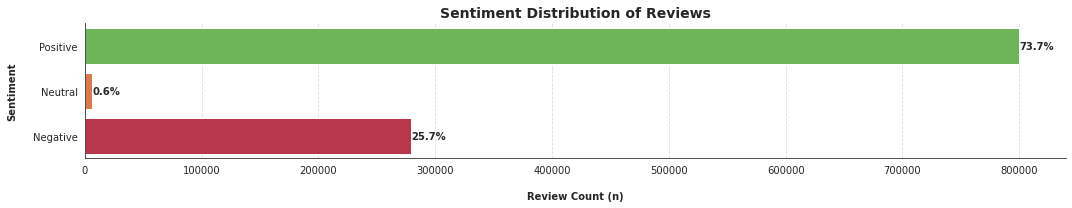

In [0]:
# ============================================
#      Analysis of Sentiment Results
# ============================================
# Count the number of reviews for each sentiment
mDeBERTa_sentiment_pd = reviews_df.groupBy("mDeBERTa_SentimentLabel") \
    .count() \
    .orderBy("count", ascending=False) \
    .toPandas() # Convert to Pandas DataFrame for visualization

# Ensure the order matches the color dict if needed for consistency
mDeBERTa_sentiment_pd = mDeBERTa_sentiment_pd.set_index('mDeBERTa_SentimentLabel').reindex(sentiment_colors.keys()).reset_index().fillna(0)

# Plot the sentiment counts
plt.figure(figsize=(15, 3))
sns.barplot(x="count", y="mDeBERTa_SentimentLabel", data=mDeBERTa_sentiment_pd,
            palette=sentiment_colors, order=sentiment_colors.keys())

plt.title("Sentiment Distribution of Reviews", fontsize=14, fontweight='bold')
plt.xlabel("\nReview Count (n)", fontsize=10, fontweight='bold')
plt.ylabel("Sentiment\n", fontsize=10, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentages on the bars
for index, value in enumerate(mDeBERTa_sentiment_pd['count']):
    percentage = (value / mDeBERTa_sentiment_pd['count'].sum()) * 100
    plt.text(value + 5, index, f"{percentage:.1f}%", va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
sns.despine(right=True, top=True)
plt.show()

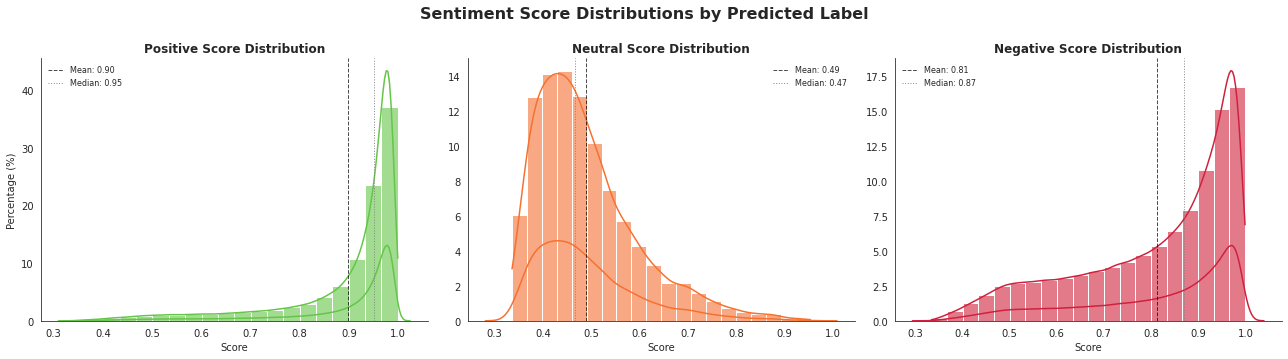

In [0]:
# Plot Score Distribution Histograms/KDE Plots
from math import ceil

# Define number of rows/cols for subplots
n_sentiments = len(sentiment_colors)
n_cols = 3
n_rows = ceil(n_sentiments / n_cols)

fig_hist, axes_hist = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False) # Ensure axes_hist is 2D array
axes_hist = axes_hist.flatten()                                                                     # Flatten for easy iteration
mDeBERTa_sentiment_pd = reviews_df.select("mDeBERTa_SentimentLabel", "mDeBERTa_SentimentScore").toPandas() # Convert to Pandas DataFrame for visualization
plot_idx = 0                                                                                        # Initialize plot index
for sentiment, color in sentiment_colors.items():
    if plot_idx < len(axes_hist):                                                                   # Check if subplot exists
        ax = axes_hist[plot_idx]
        scores = mDeBERTa_sentiment_pd[mDeBERTa_sentiment_pd["mDeBERTa_SentimentLabel"] == sentiment]["mDeBERTa_SentimentScore"]

        if not scores.empty:
            sns.histplot(scores, color=color, kde=True, stat='percent', alpha=0.6, ax=ax, bins=20)
            sns.kdeplot(scores, color=color, lw=1.5, warn_singular=False, ax=ax)

            mean_val = scores.mean()
            median_val = scores.median()
            ax.axvline(mean_val, color='black', linestyle='--', linewidth=1, alpha=0.7, label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='grey', linestyle=':', linewidth=1, alpha=0.9, label=f'Median: {median_val:.2f}')

            ax.set_title(f"{sentiment} Score Distribution", fontweight='bold')
            ax.set_xlabel("Score")
            ax.set_ylabel("Percentage (%)" if plot_idx % n_cols == 0 else "") # Y-label only on left
            ax.legend(fontsize=8, frameon=False)
            sns.despine(ax=ax, top=True, right=True)
        else:
            ax.set_title(f"{sentiment} Score Distribution\n(No Data)", fontweight='bold')
            ax.text(0.5, 0.5, "No valid scores found", ha='center', va='center', transform=ax.transAxes)
            ax.set_yticks([])
            ax.set_xticks([])
            sns.despine(ax=ax, left=True, bottom=True, top=True, right=True)

        plot_idx += 1
    else:
        break # Stop if we run out of axes

# Hide any unused subplots
for i in range(plot_idx, len(axes_hist)):
    axes_hist[i].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])                                                                   # Adjust layout to prevent title overlap
plt.suptitle("Sentiment Score Distributions by Predicted Label", fontsize=16, fontweight='bold', y=1.02)    # Add a title above all subplots
plt.show()                                                                                                  # Show the plot

### **➕ Combined Models**

In [0]:
# ============================================
#      Sentiment Models Confusion Matrix
# ============================================
# Define sentiment labels for ordering the confusion matrix
sentiment_labels = ["Positive", "Neutral", "Negative"]  # List of possible sentiment labels

# Filter out rows with null sentiment labels
clean_df = reviews_df.filter(
    F.col("TXRBSF_SentimentLabel").isNotNull() &
    F.col("mDeBERTa_SentimentLabel").isNotNull()
)  # Remove rows with null labels

# Create the confusion matrix using groupBy and pivot
conf_matrix_df = clean_df.groupBy("TXRBSF_SentimentLabel").pivot(
    "mDeBERTa_SentimentLabel",
    sentiment_labels
).count().fillna(0)  # Count occurrences and fill missing values with 0

# Order rows by sentiment_labels
# Create a temporary ordering column based on the desired sentiment_labels sequence
conf_matrix_df = conf_matrix_df.withColumn(
    "sort_order",
    F.when(F.col("TXRBSF_SentimentLabel") == "Positive", 0)
     .when(F.col("TXRBSF_SentimentLabel") == "Neutral", 1)
     .when(F.col("TXRBSF_SentimentLabel") == "Negative", 2)
     .otherwise(99) # Assign a high number for any unexpected labels
)

# Order the DataFrame by the temporary sort_order column
conf_matrix_df = conf_matrix_df.orderBy("sort_order")

# Drop the temporary ordering column
conf_matrix_df = conf_matrix_df.drop("sort_order")

# Display the confusion matrix
print("\n\033[1mConfusion Matrix (TXRBSF vs mDeBERTa Sentiment):\033[0m")
print("Rows: TXRBSF_SentimentLabel, Columns: mDeBERTa_SentimentLabel")
conf_matrix_pd = conf_matrix_df.toPandas()                                  # Convert to Pandas DataFrame for visualization
conf_matrix_pd = conf_matrix_pd.set_index("TXRBSF_SentimentLabel")          # Set TXRBSF labels as index
conf_matrix_pd.index.name = "TXRBSF Model"                                  # Rename index to 'TXRBSF Model'
conf_matrix_pd.columns.name = "mDeBERTa Model"                              # Rename columns index to 'mDeBERTa Model'
conf_matrix_pd


Confusion Matrix (TXRBSF vs mDeBERTa Sentiment):
Rows: TXRBSF_SentimentLabel, Columns: mDeBERTa_SentimentLabel


mDeBERTa Model,Positive,Neutral,Negative
TXRBSF Model,,,
Positive,525061,341,5165
Neutral,257855,5453,115891
Negative,16723,588,158354


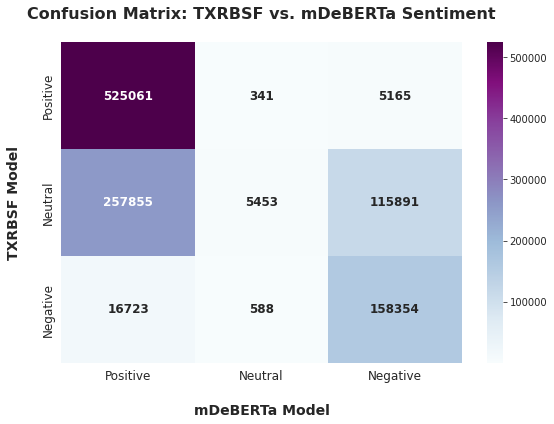

In [0]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pd, annot=True, fmt=".0f", cmap="BuPu", cbar=True,
            annot_kws={"size": 12, "weight": "bold"})
plt.title("Confusion Matrix: TXRBSF vs. mDeBERTa Sentiment\n", fontsize=16, fontweight="bold")
plt.xlabel("\nmDeBERTa Model", fontsize=14, fontweight="bold")
plt.ylabel("TXRBSF Model\n", fontsize=14, fontweight="bold")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
sns.despine(right=True, top=True, left=True, bottom=True)
plt.show()

In [0]:
# ============================================
#      Combine Sentiment Models into Single Label
# ============================================

# Define conditions and values for Combined_Sentiment
reviews_df = reviews_df.withColumn(
    "Combined_Sentiment",
    when(
        (col("TXRBSF_SentimentLabel") == "Positive") &
        (col("mDeBERTa_SentimentLabel") == "Positive"),
        "Positive"  # Both Positive
    ).when(
        (col("TXRBSF_SentimentLabel") == "Positive") &
        (col("mDeBERTa_SentimentLabel") == "Neutral"),
        "Positive Tendency"  # Positive + Neutral
    ).when(
        (col("TXRBSF_SentimentLabel") == "Positive") &
        (col("mDeBERTa_SentimentLabel") == "Negative"),
        "Neutral"  # Positive + Negative
    ).when(
        (col("TXRBSF_SentimentLabel") == "Neutral") &
        (col("mDeBERTa_SentimentLabel") == "Positive"),
        "Positive Tendency"  # Neutral + Positive
    ).when(
        (col("TXRBSF_SentimentLabel") == "Neutral") &
        (col("mDeBERTa_SentimentLabel") == "Neutral"),
        "Neutral"  # Both Neutral
    ).when(
        (col("TXRBSF_SentimentLabel") == "Neutral") &
        (col("mDeBERTa_SentimentLabel") == "Negative"),
        "Negative Tendency"  # Neutral + Negative
    ).when(
        (col("TXRBSF_SentimentLabel") == "Negative") &
        (col("mDeBERTa_SentimentLabel") == "Positive"),
        "Neutral"  # Negative + Positive
    ).when(
        (col("TXRBSF_SentimentLabel") == "Negative") &
        (col("mDeBERTa_SentimentLabel") == "Neutral"),
        "Negative Tendency"  # Negative + Neutral
    ).when(
        (col("TXRBSF_SentimentLabel") == "Negative") &
        (col("mDeBERTa_SentimentLabel") == "Negative"),
        "Negative"  # Both Negative
    ).otherwise(
        None  # Set to null if any label is null or conditions don’t match
    )
)

# Ensure Combined_Sentiment is null where either input label is null
reviews_df = reviews_df.withColumn(
    "Combined_Sentiment",
    when(
        (col("TXRBSF_SentimentLabel").isNull()) |
        (col("mDeBERTa_SentimentLabel").isNull()),
        None  # Set to null if either label is missing
    ).otherwise(col("Combined_Sentiment"))
)

# Count the occurrences of each Combined_Sentiment value
sentiment_counts = reviews_df.groupBy("Combined_Sentiment").count().orderBy(F.desc("count"))  # Group and count

# Display the value counts
print("\n\033[1mCombined Sentiment Value Counts:\033[0m")
sentiment_counts_pd = sentiment_counts.toPandas()                                              # Convert to Pandas DataFrame for visualization
sentiment_counts_pd = sentiment_counts_pd.set_index("Combined_Sentiment")                      # Set Combined_Sentiment as index
sentiment_counts_pd.index.name = "Combined Sentiment"                                          # Rename index to 'Combined Sentiment'
sentiment_counts_pd.rename(columns={"count": "n"}, inplace=True)                               # Rename count column to 'n'
sentiment_counts_pd['%'] = sentiment_counts_pd['n'] / sentiment_counts_pd['n'].sum()           # Calculate relative counts
sentiment_counts_pd['%'] = sentiment_counts_pd['%'].apply(lambda x: f"{x:.2}")                 # Round to 2 decimal places
sentiment_counts_pd


Combined Sentiment Value Counts:


,n,%
Combined Sentiment,,
Positive,525061,0.48
Positive Tendency,258196,0.24
Negative,158354,0.15
Negative Tendency,116479,0.11
Neutral,27341,0.025


### **⚒️ Feature Engineering** (For Clustering)

In [0]:
# Create a new column 'n_reviews_text' in the reviews DataFrame with the count of distinct words
reviews_df = reviews_df.withColumn("n_reviews_text", F.size(F.split(reviews_df["review_text"], " ")))

# Check the new column
reviews_df.select("review_text", "n_reviews_text").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+
|review_text                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [0]:
# Check the distribution of the number of words in reviews
reviews_df.select("n_reviews_text").describe().display()

summary,n_reviews_text
count,1085431
mean,45.15373340175469
stddev,58.860795625166205
min,2
max,3936


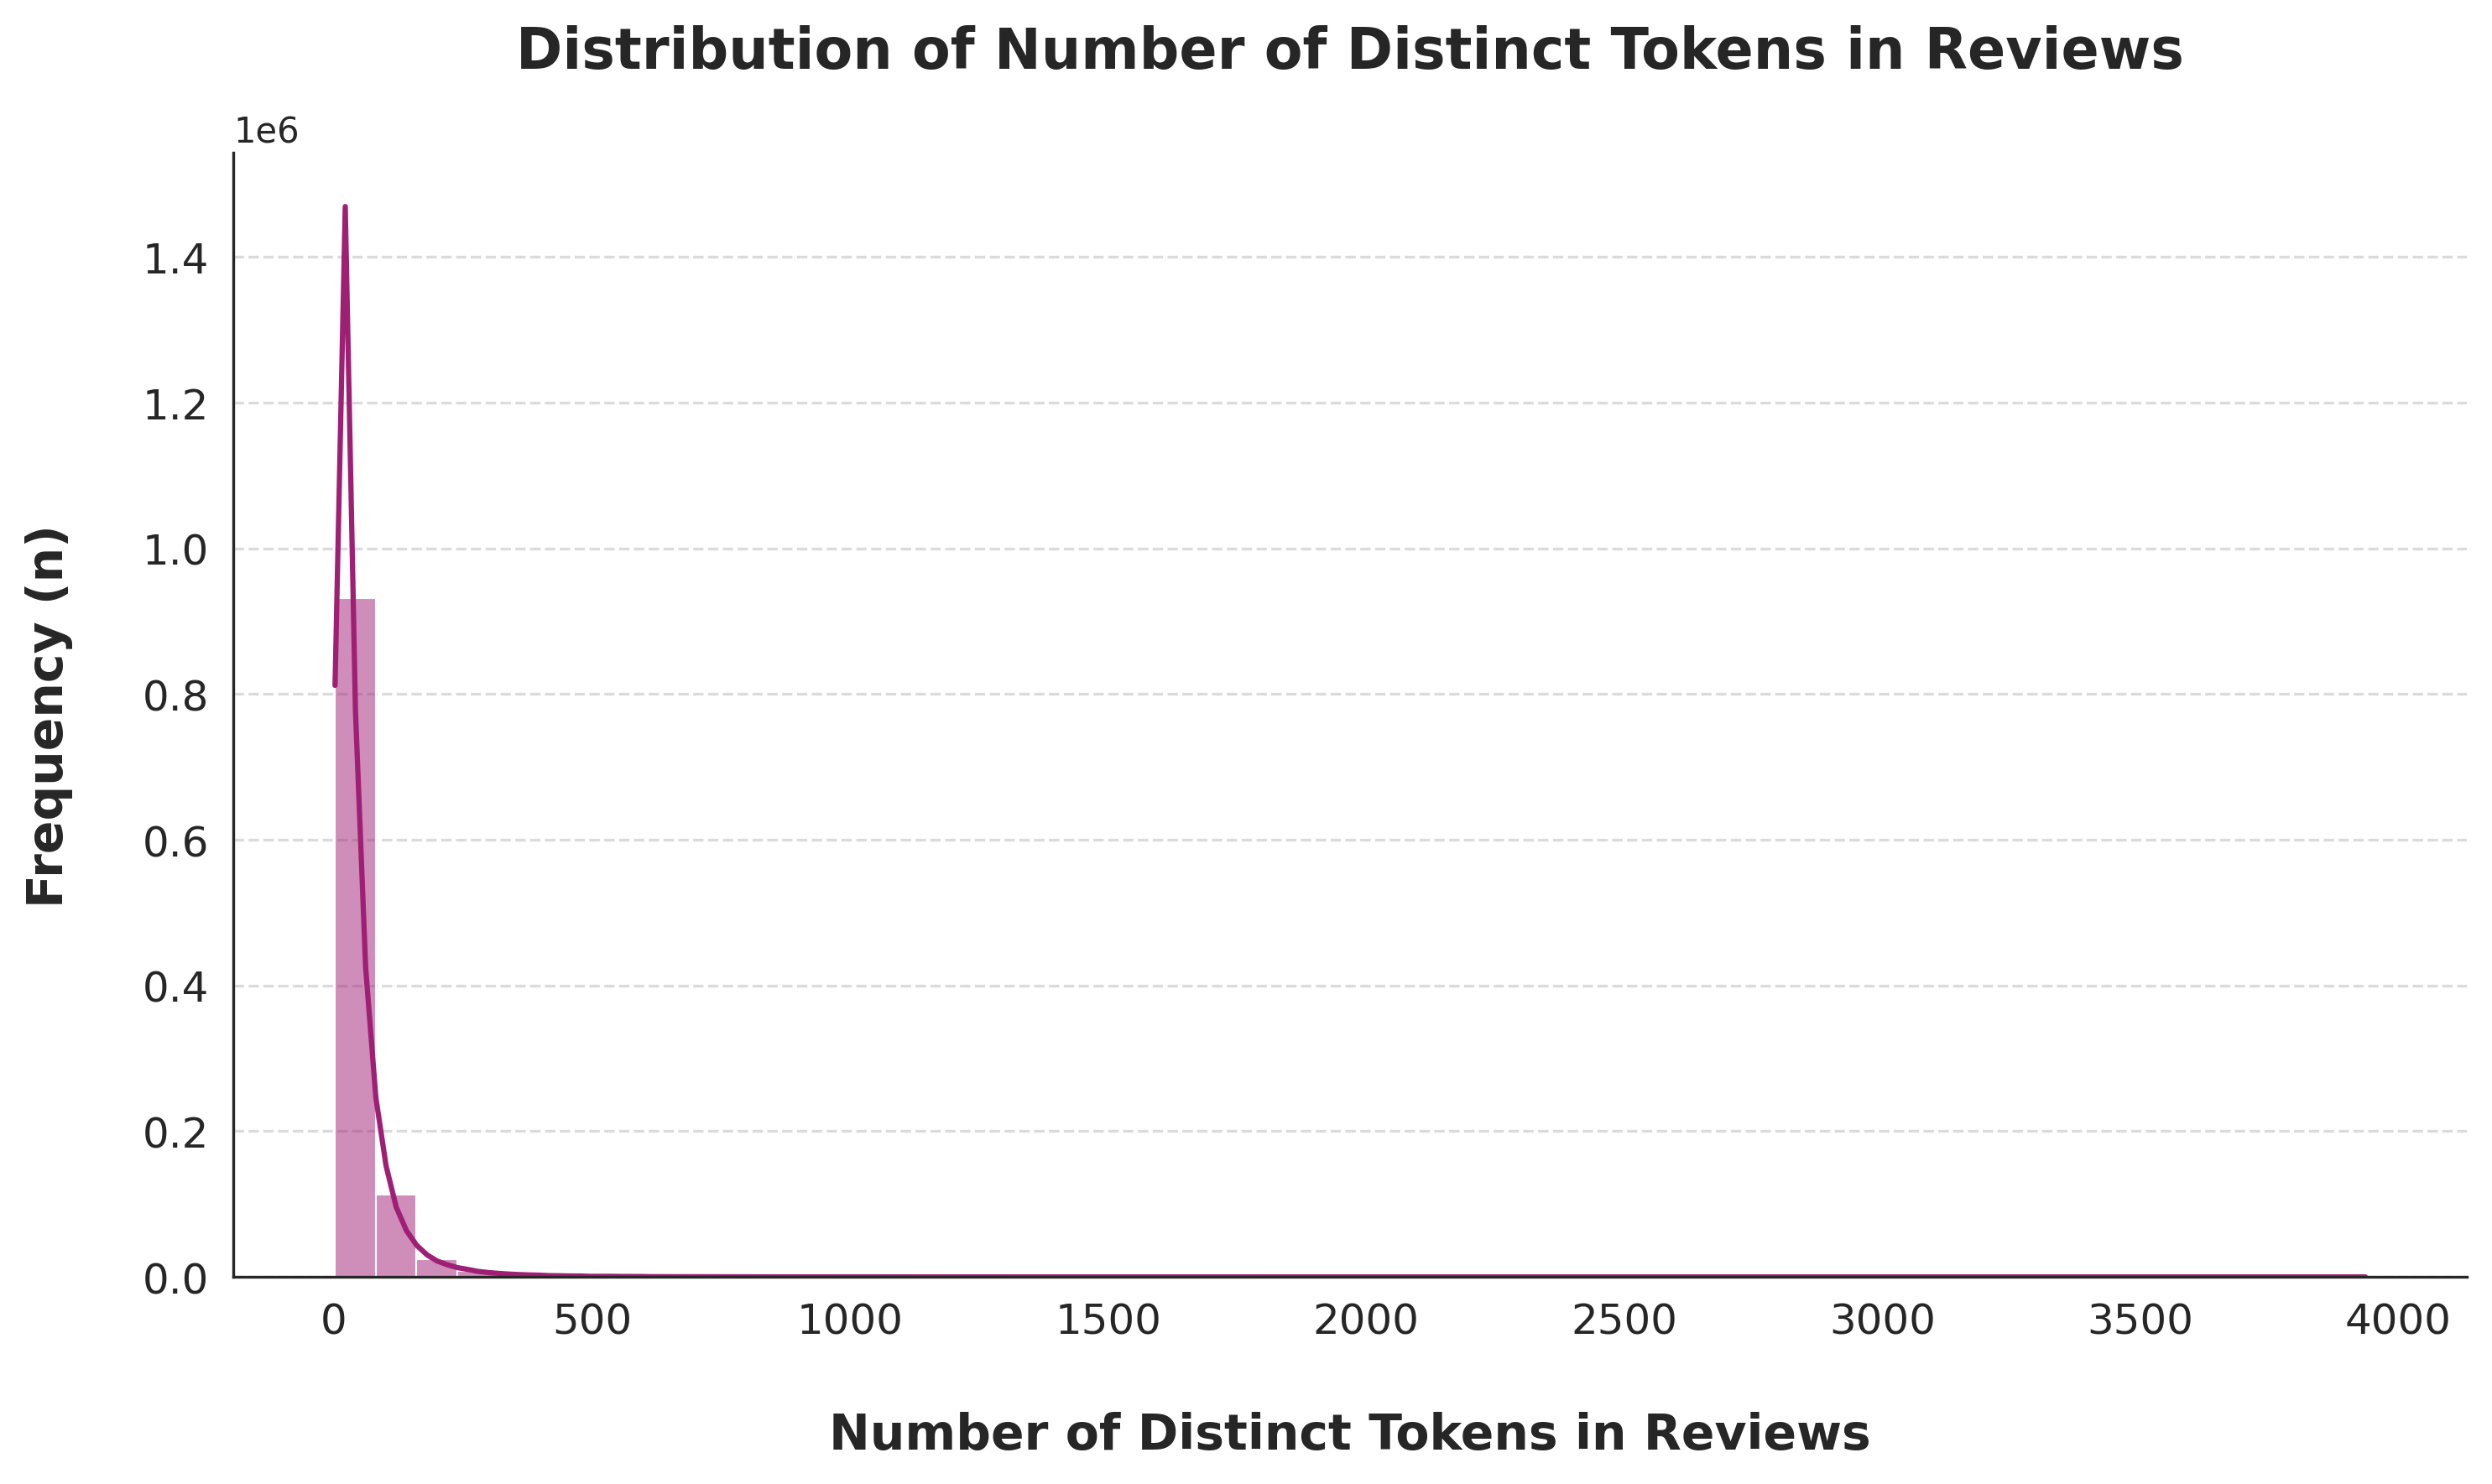

In [0]:
# Histogram of 'n_reviews_text' (Number of Words in Reviews)
plt.figure(figsize=(10, 6), dpi=300)
sns.histplot(
    reviews_df.select("n_reviews_text").toPandas(),
    x="n_reviews_text",
    bins=50,
    kde=True,
    color=color_palette[4],
    edgecolor="white",
    linewidth=0.5
)
plt.title("Distribution of Number of Distinct Tokens in Reviews\n", fontsize=16, fontweight='bold')
plt.xlabel("\nNumber of Distinct Tokens in Reviews", fontsize=14, fontweight='bold')
plt.ylabel("Frequency (n)\n", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove legend if it exists
if plt.gca().get_legend() is not None:
    plt.gca().get_legend().remove()

sns.despine(right=True, top=True)
plt.tight_layout()
plt.show()

In [0]:
displayHTML('''
## <span style="color: #ffffff;">Topic Analysis</span>
<br>
<style>
@import url('https://fonts.cdnfonts.com/css/avenir-next-lt-pro?styles=29974');
</style>

<div style="background: transparent;
            padding: 10px; color: white; border-radius: 300px; text-align: center;
            border: 2px solid #3D1C87;">
    <center><h2 style="margin-left: 120px;margin-top: 10px; margin-bottom: 4px; color: #3D1C87;
                       font-size: 34px; font-family: 'Avenir Next LT Pro', sans-serif;"><b>Topic Analysis</b></h2></center>
</div>
''')

## Topic Analysis 
 


 
 Topic Analysis

### **📦 Products/Metadata** (title)

In [0]:
# Define candidate labels for product topics based on Amazon categories
topic_candidate_labels = [
    "Laptops", "Desktops", "PC Gaming", "Monitors", "Tablets",
    "Computer Components", "Computer Accessories", "Networking",
    "Drives and Storage", "Printers and Ink", "Software", "Others" # General category
]

In [0]:
# Show the first few rows of the topic classification results
print("\n\033[1mTopic Classification Results:\033[0m")
display(products_df.limit(5))                                                                     # For Databricks


Topic Classification Results:


parent_asin,product_title,meta_average_rating,meta_rating_number,meta_price,meta_store,TopicLabel,TopicScore
0594149290,Barnes Noble Nook Glowlight 4 eReader 6 Touchscreen 32GB Black BNRV1100,4.0,12,147.95,Barnes & Noble,Drives and Storage,0.28259041905403137
059449771X,Barnes Noble Replacement Charging Sync Cable for Nook HD and HD 5 Feet,4.4,144,26.88,Barnes & Noble,Computer Accessories,0.4096800684928894
106171327X,SanDisk SDSDQUA064GA11 Professional Ultra 64GB MicroSDXC card is custom formatted for high speed lossless recording Includes Standard SD Adapter UHS1 Class 10 Certified 30MBsec for GoPro HERO4 Black,4.6,2895,8.91,SanDisk,Drives and Storage,0.6917009353637695
1254875778,Hynix 2GB DDR3 Memory SODIMM 204pin PC310600S 1333MHz HMT325S6BFR8CH9REFURB,4.2,67,11.54,Dell,Computer Components,0.7522674798965454
9875981354,Professional Ultra SanDisk 64GB MicroSDXC Card for Samsung Galaxy Note 80 Smartphone is custom formatted for high speed lossless recording Includes Standard SD Adapter UHS1 Class 10 Certified 30MBsec,4.6,585,11.96,SanDisk,Drives and Storage,0.9690341353416443


In [0]:
# Count the number of products for each topic
mDeBERTa_topic_pd = products_df.groupBy("TopicLabel") \
    .count() \
    .orderBy("count", ascending=False) \
    .toPandas()                                                                                   # Convert to Pandas DataFrame for visualization

# Absolute and Relative Table of Topic Counts
mDeBERTa_topic_pd['%'] = mDeBERTa_topic_pd['count'] / mDeBERTa_topic_pd['count'].sum()            # Calculate relative counts
mDeBERTa_topic_pd['%'] = mDeBERTa_topic_pd['%'].apply(lambda x: f"{x:.2}")                        # Round to 2 decimal places
mDeBERTa_topic_pd = mDeBERTa_topic_pd.rename(columns={"TopicLabel": "Topic", "count": "n"})       # Rename columns
mDeBERTa_topic_pd = mDeBERTa_topic_pd[["Topic", "n", "%"]]                                        # Reorder columns
mDeBERTa_topic_pd = mDeBERTa_topic_pd.set_index("Topic")                                          # Set 'Topic' as index
mDeBERTa_topic_pd

,n,%
Topic,,
Drives and Storage,12978,0.22
Laptops,11905,0.2
Computer Components,8961,0.15
Tablets,7909,0.13
Computer Accessories,7368,0.12
Monitors,3075,0.052
Networking,2990,0.05
Software,1760,0.03
Desktops,1259,0.021


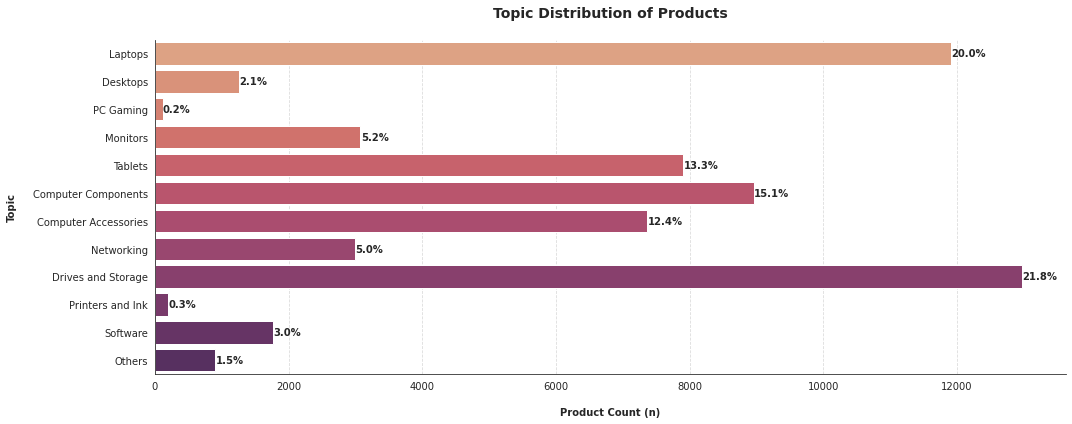

In [0]:
# ============================================
#      Analysis of Topic Results
# ============================================
# Count the number of products for each topic
mDeBERTa_topic_pd = products_df.groupBy("TopicLabel") \
    .count() \
    .orderBy(F.desc("count")) \
    .toPandas() # Convert to Pandas for visualization

# Ensure the order matches the color dict if needed for consistency
mDeBERTa_topic_pd = mDeBERTa_topic_pd.set_index('TopicLabel').reindex(topic_candidate_labels).reset_index().fillna(0)

# Create a color dictionary using the 'flare' palette
colors = sns.color_palette("flare", n_colors=len(topic_candidate_labels))  # Generate 12 colors from 'flare' palette
topic_colors = dict(zip(topic_candidate_labels, colors))                   # Map each topic to a color

# Plot the topic counts
plt.figure(figsize=(15, 6))
sns.barplot(x="count", y="TopicLabel", data=mDeBERTa_topic_pd,
            palette=topic_colors, order=topic_candidate_labels)
plt.title("Topic Distribution of Products\n", fontsize=14, fontweight='bold')
plt.xlabel("\nProduct Count (n)", fontsize=10, fontweight='bold')
plt.ylabel("Topic\n", fontsize=10, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add percentages on the bars
for index, value in enumerate(mDeBERTa_topic_pd['count']):
    percentage = (value / mDeBERTa_topic_pd['count'].sum()) * 100
    plt.text(value + 5, index, f"{percentage:.1f}%", va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
sns.despine(right=True, top=True)
plt.show()

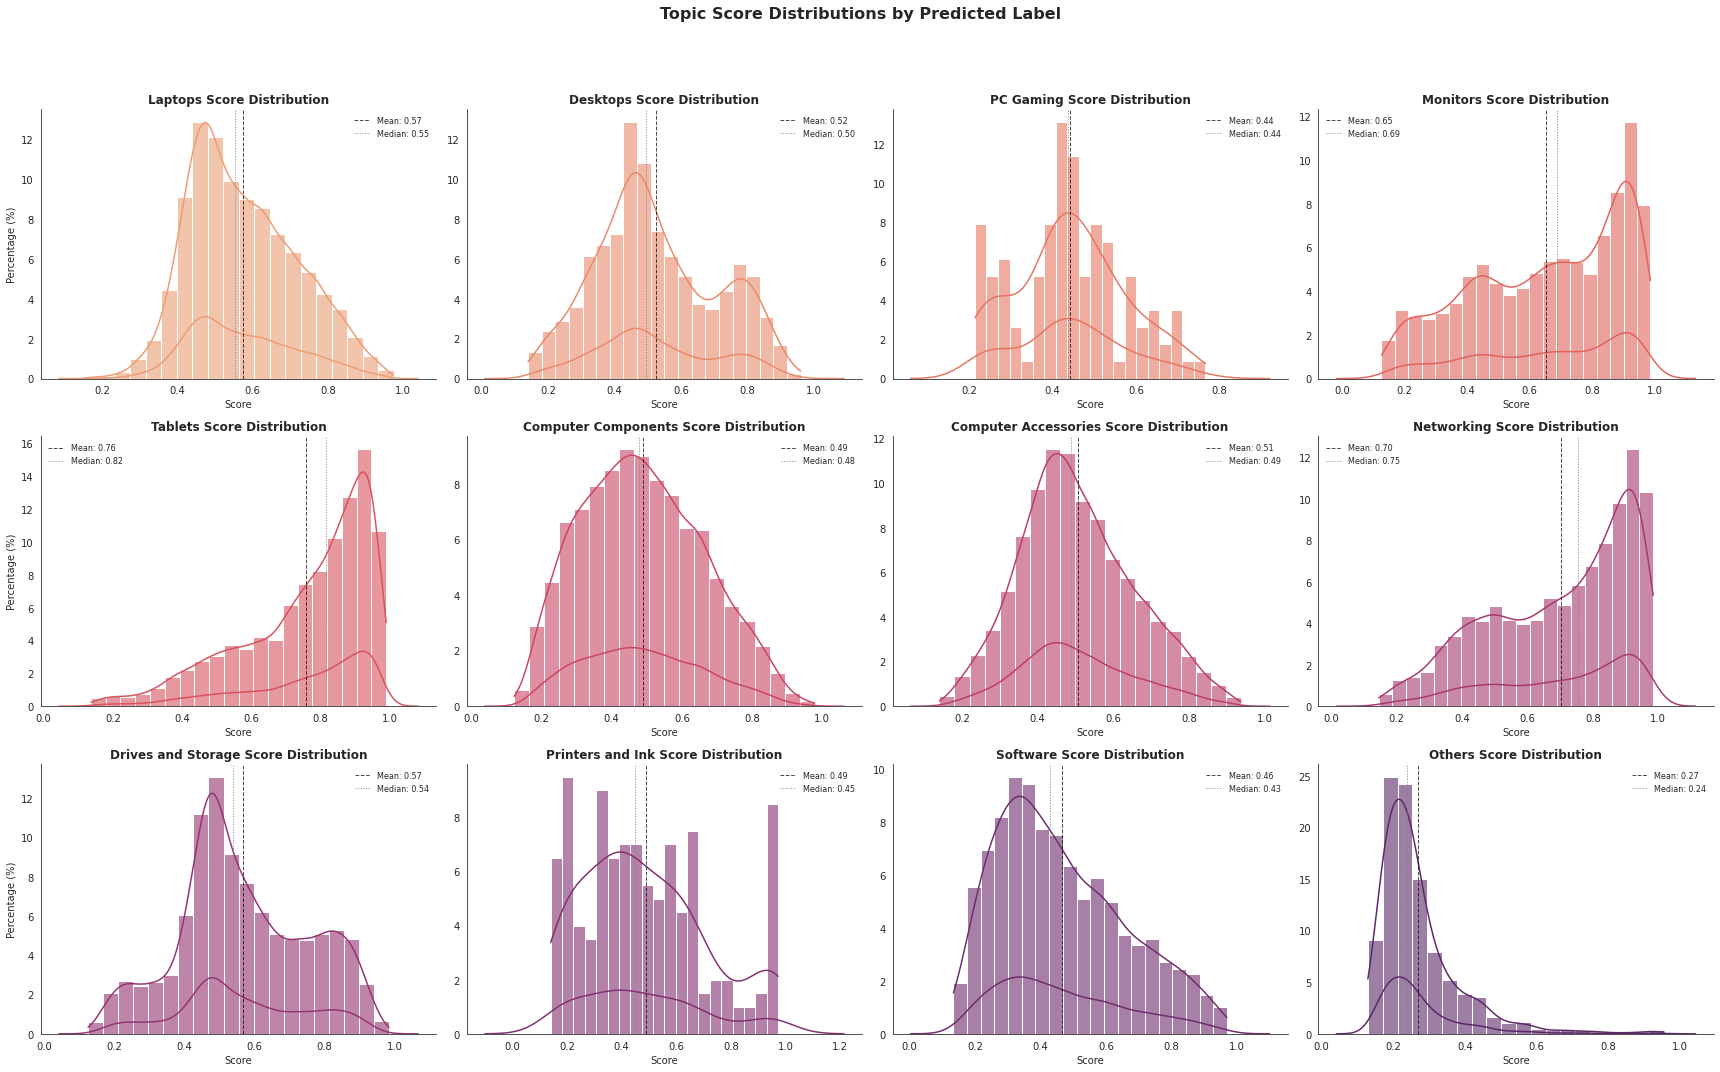

In [0]:
# Plot Score Distribution Histograms/KDE Plots
from math import ceil

# Define number of rows/cols for subplots
n_topics = len(topic_candidate_labels)
n_cols = 4
n_rows = ceil(n_topics / n_cols)
fig_hist, axes_hist = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False) # Ensure axes_hist is 2D array
axes_hist = axes_hist.flatten()                                                                     # Flatten for easy iteration
mDeBERTa_topic_pd = products_df.select("TopicLabel", "TopicScore").toPandas()                       # Convert to Pandas DataFrame for visualization
plot_idx = 0                                                                                        # Initialize plot index
for topic, color in topic_colors.items():
    if plot_idx < len(axes_hist):                                                                   # Check if subplot exists
        ax = axes_hist[plot_idx]
        scores = mDeBERTa_topic_pd[mDeBERTa_topic_pd["TopicLabel"] == topic]["TopicScore"]

        if not scores.empty:
            sns.histplot(scores, color=color, kde=True, stat='percent', alpha=0.6, ax=ax, bins=20)
            sns.kdeplot(scores, color=color, lw=1.5, warn_singular=False, ax=ax)

            mean_val = scores.mean()
            median_val = scores.median()
            ax.axvline(mean_val, color='black', linestyle='--', linewidth=1, alpha=0.7, label=f'Mean: {mean_val:.2f}')
            ax.axvline(median_val, color='grey', linestyle=':', linewidth=1, alpha=0.9, label=f'Median: {median_val:.2f}')

            ax.set_title(f"{topic} Score Distribution", fontweight='bold')
            ax.set_xlabel("Score")
            ax.set_ylabel("Percentage (%)" if plot_idx % n_cols == 0 else "") # Y-label only on left
            ax.legend(fontsize=8, frameon=False)
            sns.despine(ax=ax, top=True, right=True)
        else:
            ax.set_title(f"{topic} Score Distribution\n(No Data)", fontweight='bold')
            ax.text(0.5, 0.5, "No valid scores found", ha='center', va='center', transform=ax.transAxes)
            ax.set_yticks([])
            ax.set_xticks([])
            sns.despine(ax=ax, left=True, bottom=True, top=True, right=True)

        plot_idx += 1
    else:
        break # Stop if we run out of axes

# Hide any unused subplots
for i in range(plot_idx, len(axes_hist)):
    axes_hist[i].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])                                                                   # Adjust layout to prevent title overlap
plt.suptitle("Topic Score Distributions by Predicted Label", fontsize=16, fontweight='bold', y=1.02)        # Add a title above all subplots
plt.show()                                                                                                  # Show the plot

### **⚒️ Feature Engineering** (For Clustering)

In [0]:
# Create a new column 'n_product_title' in the products DataFrame with the count of distinct words
products_df = products_df.withColumn("n_product_title", F.size(F.split(products_df["product_title"], " ")))

# Check the new column
products_df.select("product_title", "n_product_title").show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|product_title                                                                                                                                                                                          |n_product_title|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+
|Barnes Noble Nook Glowlight 4 eReader 6 Touchscreen 32GB Black BNRV1100                                                                                                                                |11             |
|Barnes Noble Replacement Charging Sync Cable for Nook HD and HD 5 Feet                                                         

In [0]:
# Check the distribution of the number of words in the 'product_title' column
products_df.select("n_product_title").describe().display()

summary,n_product_title
count,59418
mean,21.91702850987916
stddev,7.749703987017272
min,1
max,91


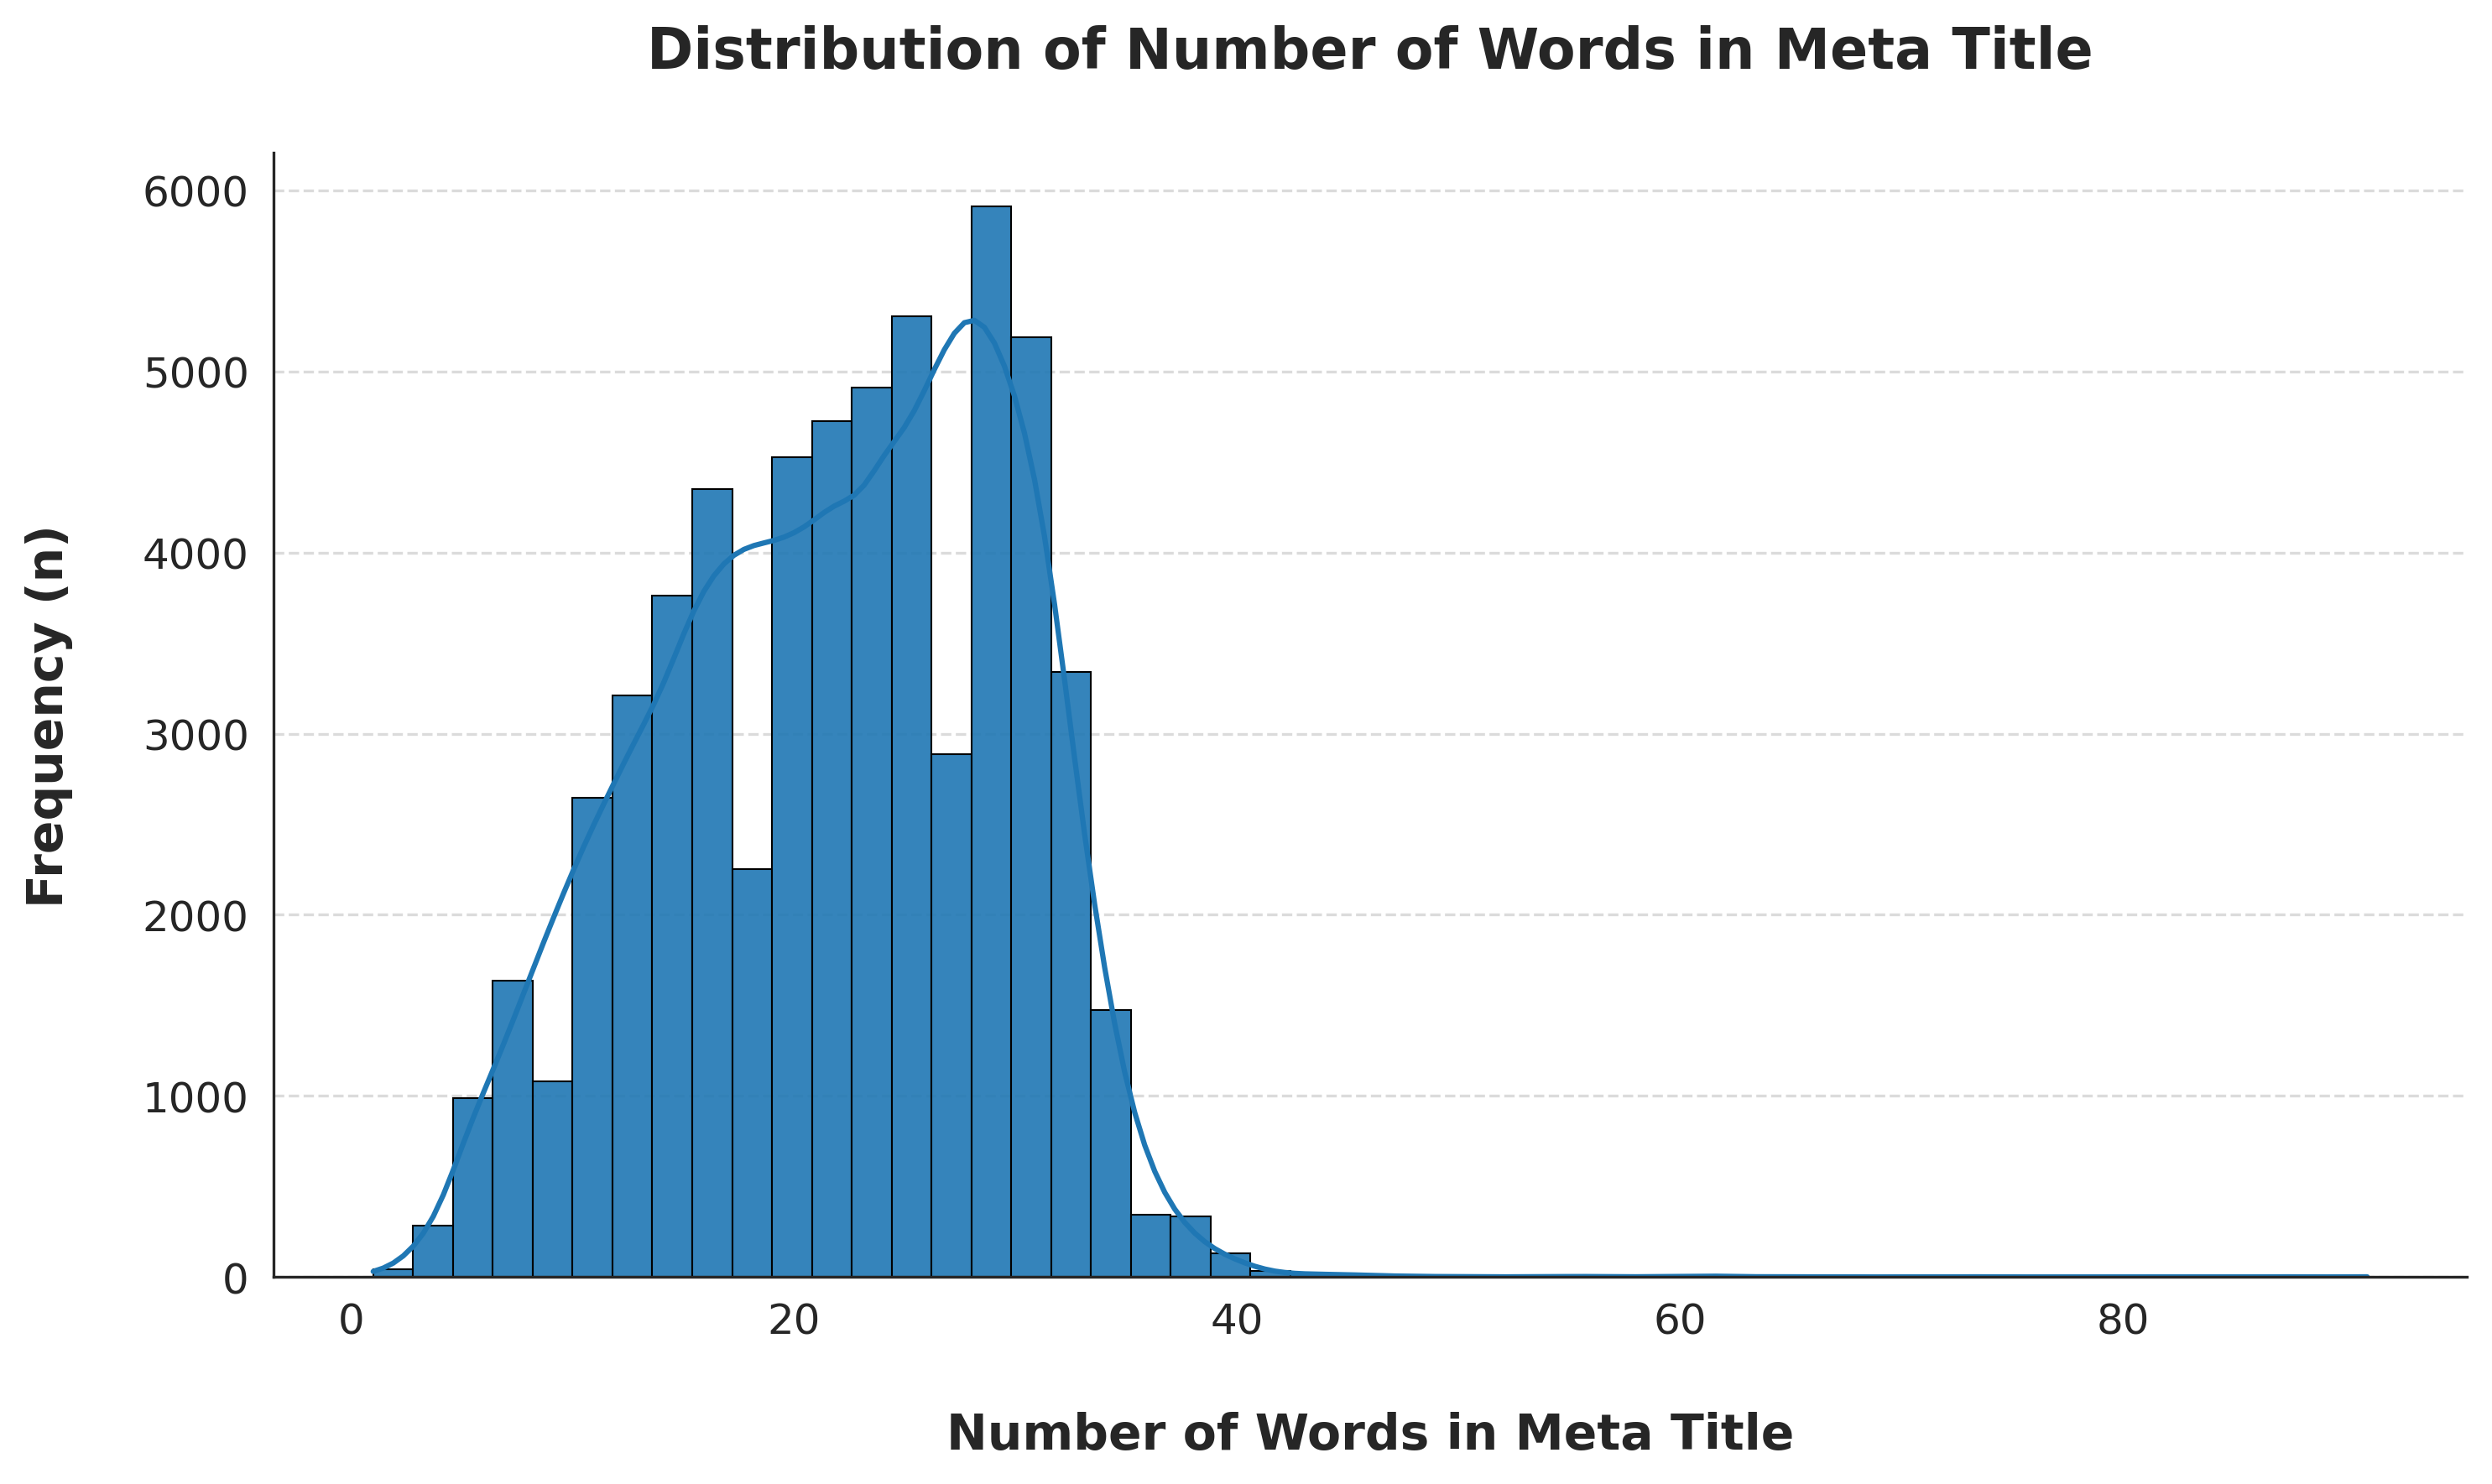

In [0]:
# Histogram of 'n_product_title' Distribution
plt.figure(figsize=(10, 6), dpi=300)
sns.histplot(
    products_df.select("n_product_title").toPandas(),
    bins=50,
    kde=True,
    color=color_palette[0],
    alpha=0.9,
    edgecolor="black",
    linewidth=0.5
)
plt.title("Distribution of Number of Words in Meta Title\n", fontsize=16, fontweight='bold')
plt.xlabel("\nNumber of Words in Meta Title", fontsize=14, fontweight='bold')
plt.ylabel("Frequency (n)\n", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove legend if it exists
if plt.gca().get_legend() is not None:
    plt.gca().get_legend().remove()

sns.despine(right=True, top=True)
plt.tight_layout()
plt.show()

---

## **👀 Analysis of the Results**

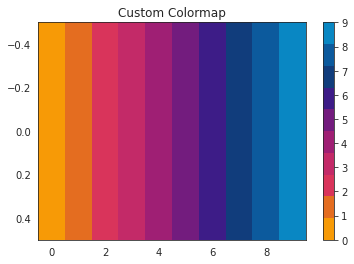

In [0]:
from matplotlib.colors import ListedColormap, to_rgba_array

# Create a colormap from the color palette
cmap = ListedColormap(color_palette)

# Example usage: Plot a gradient to visualize the colormap
plt.imshow([list(range(len(color_palette)))], cmap=cmap, aspect='auto')
plt.colorbar()
plt.title('Custom Colormap')
plt.show()

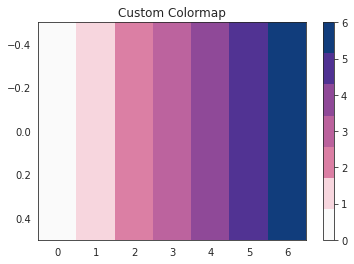

In [0]:
# Create a colormap with transparency
color_palette_transparent = [
    to_rgba_array('#f0f0f0', alpha=0.3),
    to_rgba_array(color_palette[2], alpha=0.2),
    to_rgba_array(color_palette[3], alpha=0.6),
    to_rgba_array(color_palette[4], alpha=0.7),
    to_rgba_array(color_palette[5], alpha=0.8),
    to_rgba_array(color_palette[6], alpha=0.9),
    to_rgba_array(color_palette[7], alpha=1.0)
]


# Create a colormap from the color palette
cmap_t = ListedColormap(color_palette_transparent)

# Example usage: Plot a gradient to visualize the colormap
plt.imshow([list(range(len(color_palette_transparent)))], cmap=cmap_t, aspect='auto')
plt.colorbar()
plt.title('Custom Colormap')
plt.show()

### **Combined Sentiment (5) vs. Topics (12)**

In [0]:
# Join reviews and products on parent_asin to link sentiments with topics
combined_df = reviews_df.join(products_df.select("parent_asin", "TopicLabel"),
                             on="parent_asin", how="inner")

# Group by Combined_Sentiment and TopicLabel
sentiment_topic_df = combined_df.groupBy("Combined_Sentiment", "TopicLabel").count().toPandas()
sentiment_topic_pivot = sentiment_topic_df.pivot(index="TopicLabel", columns="Combined_Sentiment", values="count").fillna(0)

# Ensure all topics and sentiments are included
sentiment_order = ["Positive", "Positive Tendency", "Neutral", "Negative Tendency", "Negative"]
sentiment_topic_pivot = sentiment_topic_pivot.reindex(topic_candidate_labels).reindex(columns=sentiment_order).fillna(0)
sentiment_topic_pivot = sentiment_topic_pivot[['Negative', 'Negative Tendency', 'Neutral', 'Positive Tendency', 'Positive']]

# Calculate row totals
row_totals = sentiment_topic_pivot.sum(axis=1)

# Calculate percentages
sentiment_topic_pivot_percentages = sentiment_topic_pivot.apply(lambda row: row.apply(lambda x: f"{int(x)} ({x / row_totals[row.name] * 100:.1f}%)"), axis=1)
sentiment_topic_pivot_percentages

Combined_Sentiment,Negative,Negative Tendency,Neutral,Positive Tendency,Positive
TopicLabel,,,,,
Laptops,23044 (17.1%),15137 (11.3%),3486 (2.6%),28704 (21.3%),64074 (47.7%)
Desktops,1745 (10.4%),1881 (11.2%),472 (2.8%),4829 (28.8%),7855 (46.8%)
PC Gaming,193 (13.0%),182 (12.3%),43 (2.9%),410 (27.7%),651 (44.0%)
Monitors,8867 (13.6%),7192 (11.1%),1997 (3.1%),14483 (22.3%),32436 (49.9%)
Tablets,32729 (15.4%),18748 (8.8%),5434 (2.6%),38256 (18.0%),117313 (55.2%)
Computer Components,11252 (11.4%),12005 (12.1%),2810 (2.8%),30190 (30.5%),42827 (43.2%)
Computer Accessories,27499 (14.3%),18670 (9.7%),5114 (2.7%),42475 (22.1%),98172 (51.1%)
Networking,13931 (15.6%),11077 (12.4%),1961 (2.2%),26421 (29.5%),36082 (40.3%)
Drives and Storage,33957 (13.9%),27642 (11.4%),5149 (2.1%),64039 (26.3%),112642 (46.3%)


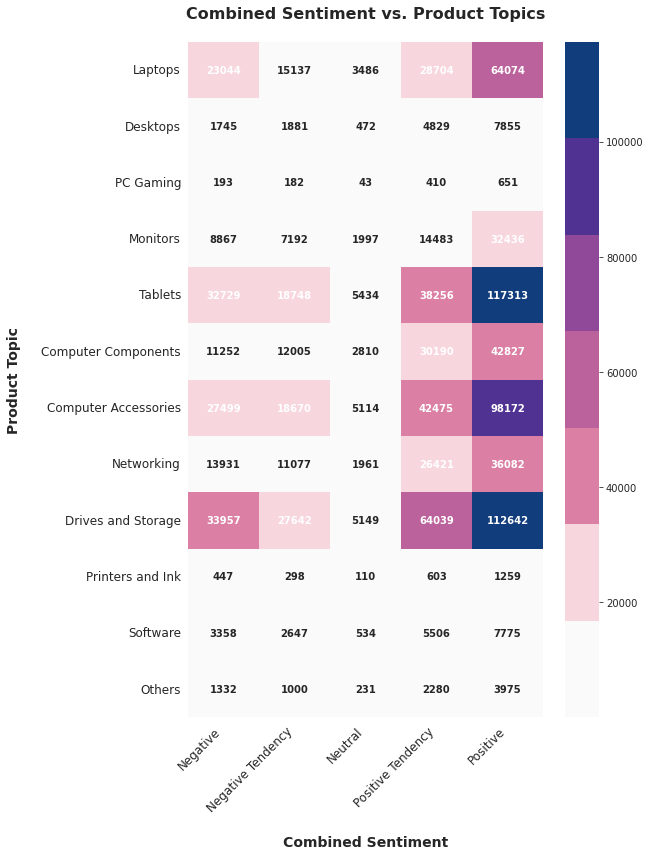

In [0]:
# Plot heatmap
plt.figure(figsize=(9, 12))
sns.heatmap(sentiment_topic_pivot, annot=True, fmt=".0f", cmap=cmap_t, cbar=True,
            annot_kws={"size": 10, "weight": "bold"})
plt.title("Combined Sentiment vs. Product Topics\n", fontsize=16, fontweight="bold")
plt.xlabel("\nCombined Sentiment", fontsize=14, fontweight="bold")
plt.ylabel("Product Topic\n", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
sns.despine(right=True, top=True, left=True, bottom=True)
plt.show()

### **Price (Buckets) vs. Combined Sentiment (5)**

In [0]:
# Create a new column 'price_category' in the products DataFrame to categorize products by price
products_with_price_category = products_df.withColumn(
    "price_category",
    F.when(F.col("meta_price").between(0, 10), "0 - 10")
     .when(F.col("meta_price").between(10, 50), "10 - 50")
     .when(F.col("meta_price").between(50, 100), "50 - 100")
     .when(F.col("meta_price").between(100, 250), "100 - 250")
     .when(F.col("meta_price").between(250, 500), "250 - 500")
     .when(F.col("meta_price") >= 500, "500+")
     .otherwise(None)
)

# Check if are some case with 'None'
products_with_price_category.filter(F.col("price_category").isNull()).count()

Out[52]: 0

In [0]:
# Join with reviews to get Combined_Sentiment
price_sentiment_df = reviews_df.join(
    products_with_price_category.select("parent_asin", "price_category"),
    on="parent_asin", how="inner"
).groupBy("price_category", "Combined_Sentiment").count().toPandas()

# Pivot for heatmap
price_sentiment_pivot = price_sentiment_df.pivot(index="price_category", columns="Combined_Sentiment", values="count").fillna(0)
price_order = ["0 - 10", "10 - 50", "50 - 100", "100 - 250", "250 - 500", "500+"]
sentiment_order = ["Positive", "Positive Tendency", "Neutral", "Negative Tendency", "Negative"]
price_sentiment_pivot = price_sentiment_pivot.reindex(price_order).reindex(columns=sentiment_order).fillna(0)
price_sentiment_pivot = price_sentiment_pivot[['Negative', 'Negative Tendency', 'Neutral', 'Positive Tendency', 'Positive']]

# Calculate row totals
row_totals = price_sentiment_pivot.sum(axis=1)

# Calculate percentages
price_sentiment_pivot_percentages = price_sentiment_pivot.apply(lambda row: row.apply(lambda x: f"{int(x)} ({x / row_totals[row.name] * 100:.1f}%)"), axis=1)
price_sentiment_pivot_percentages

Combined_Sentiment,Negative,Negative Tendency,Neutral,Positive Tendency,Positive
price_category,,,,,
0 - 10,15967 (14.7%),11152 (10.3%),2523 (2.3%),28919 (26.7%),49877 (46.0%)
10 - 50,83618 (14.1%),57187 (9.7%),14362 (2.4%),137872 (23.3%),299363 (50.5%)
50 - 100,20333 (15.5%),15430 (11.7%),3467 (2.6%),32399 (24.7%),59795 (45.5%)
100 - 250,22864 (15.0%),18923 (12.4%),4145 (2.7%),36604 (24.0%),70155 (45.9%)
250 - 500,9232 (15.2%),7755 (12.8%),1571 (2.6%),13864 (22.9%),28172 (46.5%)
500+,6340 (15.9%),6032 (15.1%),1273 (3.2%),8538 (21.4%),17699 (44.4%)


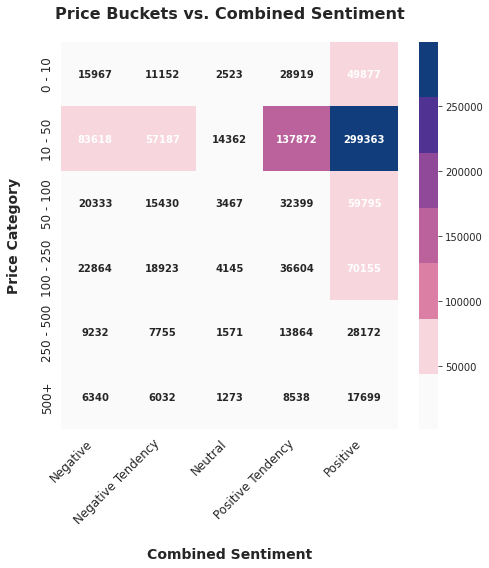

In [0]:
# Plot heatmap
plt.figure(figsize=(7, 8))
sns.heatmap(price_sentiment_pivot, annot=True, fmt=".0f", cmap=cmap_t, cbar=True,
            annot_kws={"size": 10, "weight": "bold"})
plt.title("Price Buckets vs. Combined Sentiment\n", fontsize=16, fontweight="bold")
plt.xlabel("\nCombined Sentiment", fontsize=14, fontweight="bold")
plt.ylabel("Price Category\n", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
sns.despine(right=True, top=True, left=True, bottom=True)
plt.show()

### **Price vs. Topics (12)**

In [0]:
# Group by price_category and TopicLabel
price_topic_df = products_with_price_category.groupBy("price_category", "TopicLabel").count().toPandas()
price_topic_pivot = price_topic_df.pivot(index="TopicLabel", columns="price_category", values="count").fillna(0)
price_topic_pivot = price_topic_pivot.reindex(topic_candidate_labels).reindex(columns=price_order).fillna(0)

# Calculate row totals
row_totals = price_topic_pivot.sum(axis=1)

# Calculate percentages
price_topic_pivot_percentages = price_topic_pivot.apply(lambda row: row.apply(lambda x: f"{int(x)} ({x / row_totals[row.name] * 100:.1f}%)"), axis=1)
price_topic_pivot_percentages

price_category,0 - 10,10 - 50,50 - 100,100 - 250,250 - 500,500+
TopicLabel,,,,,,
Laptops,1387 (11.7%),5859 (49.2%),1025 (8.6%),1099 (9.2%),920 (7.7%),1615 (13.6%)
Desktops,118 (9.4%),466 (37.0%),187 (14.9%),265 (21.0%),109 (8.7%),114 (9.1%)
PC Gaming,12 (10.5%),31 (27.2%),22 (19.3%),21 (18.4%),9 (7.9%),19 (16.7%)
Monitors,178 (5.8%),691 (22.5%),693 (22.5%),858 (27.9%),438 (14.2%),217 (7.1%)
Tablets,1053 (13.3%),5250 (66.4%),814 (10.3%),557 (7.0%),170 (2.1%),65 (0.8%)
Computer Components,1511 (16.9%),4087 (45.6%),1306 (14.6%),1309 (14.6%),421 (4.7%),327 (3.6%)
Computer Accessories,2046 (27.8%),4198 (57.0%),737 (10.0%),319 (4.3%),57 (0.8%),11 (0.1%)
Networking,389 (13.0%),1260 (42.1%),532 (17.8%),506 (16.9%),202 (6.8%),101 (3.4%)
Drives and Storage,1302 (10.0%),4233 (32.6%),1149 (8.9%),1921 (14.8%),1629 (12.6%),2744 (21.1%)


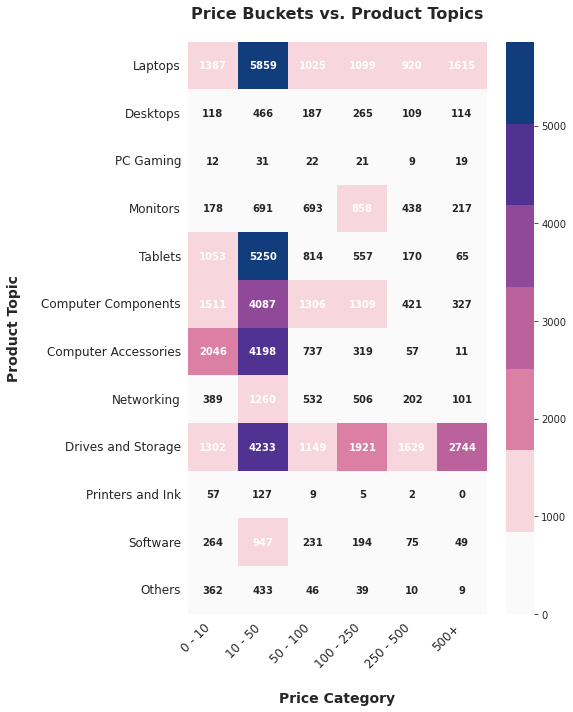

In [0]:
# Plot heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(price_topic_pivot, annot=True, fmt=".0f", cmap=cmap_t, cbar=True,
            annot_kws={"size": 10, "weight": "bold"})
plt.title("Price Buckets vs. Product Topics\n", fontsize=16, fontweight="bold")
plt.xlabel("\nPrice Category", fontsize=14, fontweight="bold")
plt.ylabel("Product Topic\n", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
sns.despine(right=True, top=True, left=True, bottom=True)
plt.show()

### **Store (Top 10) vs. Combined Sentiment (5)**

In [0]:
# Get top 10 stores
store_counts = products_df.groupBy("meta_store").agg(F.count("*").alias("n")).orderBy(F.desc("n"))
top_stores = store_counts.limit(10).select("meta_store").toPandas()["meta_store"].tolist()

# Join reviews with products and filter for top 10 stores
store_sentiment_df = reviews_df.join(
    products_df.select("parent_asin", "meta_store"),
    on="parent_asin", how="inner"
).filter(F.col("meta_store").isin(top_stores)).groupBy("meta_store", "Combined_Sentiment").count().toPandas()

# Pivot for heatmap
store_sentiment_pivot = store_sentiment_df.pivot(index="meta_store", columns="Combined_Sentiment", values="count").fillna(0)
store_sentiment_pivot = store_sentiment_pivot.reindex(top_stores).reindex(columns=sentiment_order).fillna(0)
store_sentiment_pivot = store_sentiment_pivot[['Negative', 'Negative Tendency', 'Neutral', 'Positive Tendency', 'Positive']]

# Calculate row totals
row_totals = store_sentiment_pivot.sum(axis=1)

# Calculate percentages
store_sentiment_pivot_percentages = store_sentiment_pivot.apply(lambda row: row.apply(lambda x: f"{int(x)} ({x / row_totals[row.name] * 100:.1f}%)"), axis=1)
store_sentiment_pivot_percentages

Combined_Sentiment,Negative,Negative Tendency,Neutral,Positive Tendency,Positive
meta_store,,,,,
Amazon Renewed,7716 (18.1%),5657 (13.3%),1068 (2.5%),7905 (18.6%),20258 (47.5%)
HP,3175 (19.5%),2267 (13.9%),497 (3.1%),3091 (19.0%),7263 (44.6%)
Lenovo,1697 (19.3%),1215 (13.8%),243 (2.8%),1611 (18.3%),4043 (45.9%)
ASUS,2663 (16.0%),2628 (15.8%),523 (3.1%),4103 (24.6%),6749 (40.5%)
Dell,1342 (18.8%),1129 (15.8%),185 (2.6%),1567 (22.0%),2909 (40.8%)
SanDisk,2488 (9.9%),2356 (9.4%),521 (2.1%),7399 (29.6%),12244 (49.0%)
SAMSUNG,3400 (12.7%),2958 (11.0%),588 (2.2%),6863 (25.6%),13032 (48.6%)
Generic,232 (20.4%),138 (12.2%),25 (2.2%),279 (24.6%),461 (40.6%)
MOSISO,2209 (19.2%),1063 (9.2%),366 (3.2%),1890 (16.4%),5971 (51.9%)


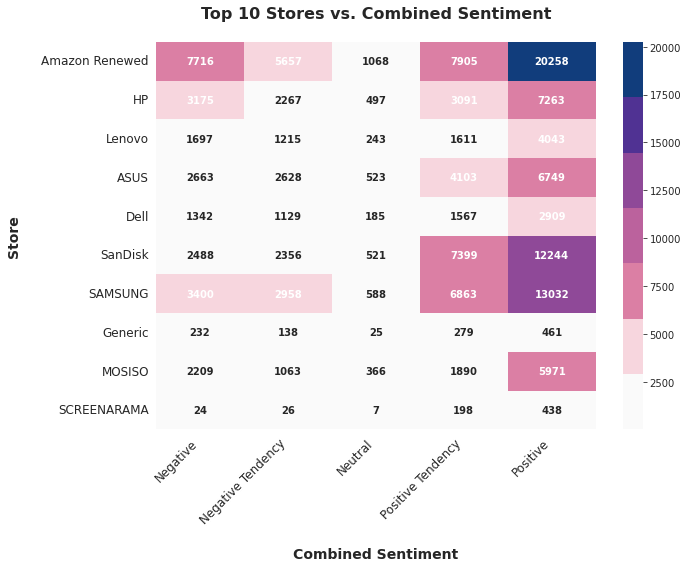

In [0]:
# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(store_sentiment_pivot, annot=True, fmt=".0f", cmap=cmap_t, cbar=True,
            annot_kws={"size": 10, "weight": "bold"})
plt.title("Top 10 Stores vs. Combined Sentiment\n", fontsize=16, fontweight="bold")
plt.xlabel("\nCombined Sentiment", fontsize=14, fontweight="bold")
plt.ylabel("Store\n", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
sns.despine(right=True, top=True, left=True, bottom=True)
plt.show()

### **Review Score "True" vs. "Predicted" (Classification Matrix as Heatmap)**

In [0]:
# Group by rating_category and Combined_Sentiment
rating_sentiment_df = reviews_df.groupBy("rating", "Combined_Sentiment").count().toPandas()
rating_sentiment_pivot = rating_sentiment_df.pivot(index="rating", columns="Combined_Sentiment", values="count").fillna(0)
rating_sentiment_pivot.index.name = "True Rating Category"
rating_sentiment_pivot.columns.name = "Predicted Combined Sentiment"
rating_sentiment_pivot = rating_sentiment_pivot[['Negative', 'Negative Tendency', 'Neutral', 'Positive Tendency', 'Positive']]
# Calculate row totals
row_totals = rating_sentiment_pivot.sum(axis=1)

# Calculate percentages
rating_sentiment_pivot_percentages = rating_sentiment_pivot.apply(lambda row: row.apply(lambda x: f"{int(x)} ({x / row_totals[row.name] * 100:.1f}%)"), axis=1)

rating_sentiment_pivot_percentages

Predicted Combined Sentiment,Negative,Negative Tendency,Neutral,Positive Tendency,Positive
True Rating Category,,,,,
1,103332 (61.9%),49805 (29.9%),4274 (2.6%),8393 (5.0%),1039 (0.6%)
2,26637 (45.8%),20173 (34.7%),2862 (4.9%),7311 (12.6%),1150 (2.0%)
3,18539 (27.1%),21712 (31.8%),5005 (7.3%),18551 (27.1%),4548 (6.7%)
4,5628 (5.3%),12828 (12.0%),5809 (5.5%),43060 (40.4%),39148 (36.8%)
5,4218 (0.6%),11961 (1.7%),9391 (1.4%),180881 (26.4%),479176 (69.9%)


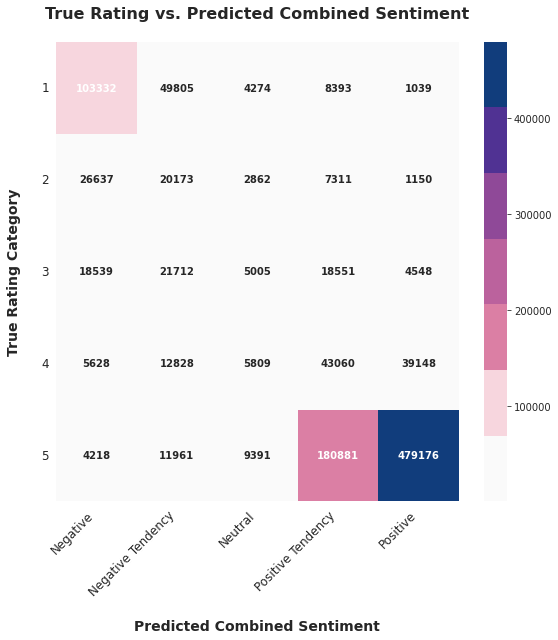

In [0]:
# Plot heatmap
plt.figure(figsize=(8, 9))
sns.heatmap(rating_sentiment_pivot, annot=True, fmt=".0f", cmap=cmap_t, cbar=True,
            annot_kws={"size": 10, "weight": "bold"})
plt.title("True Rating vs. Predicted Combined Sentiment\n", fontsize=16, fontweight="bold")
plt.xlabel("\nPredicted Combined Sentiment", fontsize=14, fontweight="bold")
plt.ylabel("True Rating Category\n", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
sns.despine(right=True, top=True, left=True, bottom=True)
plt.show()

### **Temporal Analysis: True Average Rating vs. Predicted Sentiment**

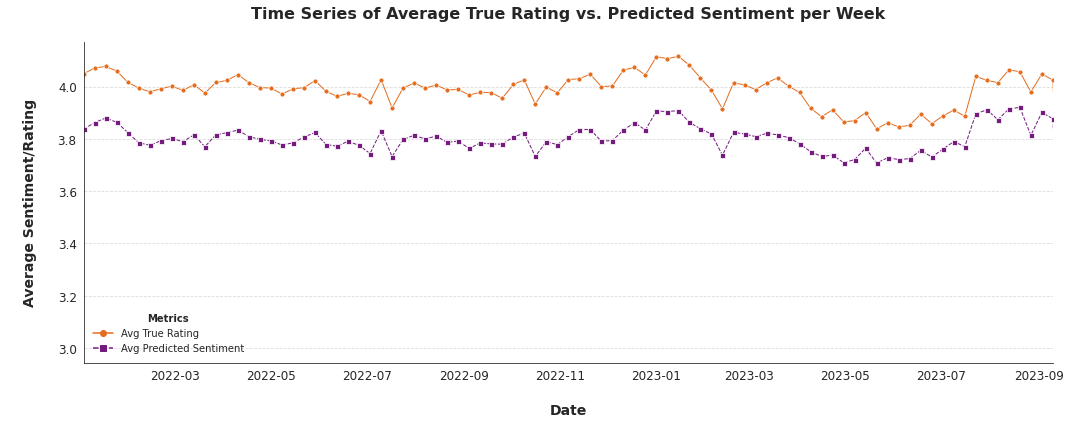

In [0]:
# Convert Combined_Sentiment to a numerical score for averaging
reviews_temporal = reviews_df.withColumn(
    "sentiment_score",
    F.when(F.col("Combined_Sentiment") == "Positive", 5.0)
     .when(F.col("Combined_Sentiment") == "Positive Tendency", 4.0)
     .when(F.col("Combined_Sentiment") == "Neutral", 3.0)
     .when(F.col("Combined_Sentiment") == "Negative Tendency", 2.0)
     .when(F.col("Combined_Sentiment") == "Negative", 1.0)
     .otherwise(None)
)

# Group by week
reviews_temporal_pd = reviews_temporal.select("rating", "sentiment_score", "timestamp_dt").toPandas()
reviews_temporal_pd["timestamp_dt"] = pd.to_datetime(reviews_temporal_pd["timestamp_dt"])
weekly_stats = reviews_temporal_pd.groupby(pd.Grouper(key="timestamp_dt", freq="W")).agg(
    {"rating": "mean", "sentiment_score": "mean", "timestamp_dt": "count"}
).rename(columns={"timestamp_dt": "review_count", "rating": "avg_true_rating", "sentiment_score": "avg_predicted_sentiment"})

# Plot time series
fig, ax1 = plt.subplots(figsize=(15, 6))
sns.lineplot(data=weekly_stats, x=weekly_stats.index, y="avg_true_rating",
             color=color_palette[1], ax=ax1, linewidth=1, marker="o", markersize=5, label="True Rating")
sns.lineplot(data=weekly_stats, x=weekly_stats.index, y="avg_predicted_sentiment",
             color=color_palette[5], ax=ax1, linestyle="--", linewidth=1, marker="s", markersize=5, label="Predicted Sentiment")
ax1.set_title("Time Series of Average True Rating vs. Predicted Sentiment per Week\n", fontsize=16, fontweight="bold")
ax1.set_ylabel("\nAverage Sentiment/Rating\n", fontweight="bold", fontsize=14)
ax1.set_xlabel("\nDate", fontweight="bold", fontsize=14)
ax1.set_xlim(weekly_stats.index.min(), weekly_stats.index.max()- pd.Timedelta(days=7))
ax1.tick_params(axis="both", labelsize=12)
ax1.grid(axis="y", linestyle="--", alpha=0.7)
legend_lines = [
    mlines.Line2D([], [], color=color_palette[1], marker="o"),
    mlines.Line2D([], [], color=color_palette[5], linestyle="--", marker="s")
]
ax1.legend(legend_lines, ["Avg True Rating", "Avg Predicted Sentiment"], title="Metrics",  title_fontproperties={'weight':'bold',  'size':'10'},
           fontsize=10, loc="best", frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

---

# **💾 Save Data**

In [0]:
# # Create a new directory for saving final DataFrames
# if not os.path.exists("AmazonReviews_Results"):                # Google Collab
#     os.makedirs("AmazonReviews_Results")

dbutils.fs.mkdirs("dbfs:/FileStore/AmazonReviews_Results")       # Databricks

Out[62]: True

In [0]:
# Save preprocessed datasets as parquet (Products_df)
(products_df
 .write.mode("overwrite")
#  .parquet("./data/AmazonReviews_Results/df-computers-products-final"))          # Local Path
#  .parquet("/content/AmazonReviews_Results/df-computers-products-final"))        # Google Colab Path
 .parquet("dbfs:/FileStore/AmazonReviews_Results/df-computers-products-final"))  # Databricks Path

In [0]:
# Save preprocessed datasets as parquet (Reviews_df)
(reviews_df
 .repartition(5)
 .write.mode("overwrite")
#  .parquet("./data/AmazonReviews_Results/df-computers-reviews-final"))           # Local Path
#  .parquet("/content/AmazonReviews_Results/df-computers-reviews-final"))         # Google Colab Path
 .parquet("dbfs:/FileStore/AmazonReviews_Results/df-computers-reviews-final"))  # Databricks Path

In [0]:
# # Extra: Save preprocessed datasets as .zip in Google Drive
# import shutil

# # Compress the Parquet directory into a ZIP file
# # reviews_df
# zip_path = "/content/AmazonReviews_Results/df-computers-reviews-final.zip"
# shutil.make_archive("/content/AmazonReviews_Results/df-computers-reviews-final", "zip", "/content/AmazonReviews_Results/df-computers-reviews-final")
# print(f"Parquet directory compressed to {zip_path}")

# # products_df
# zip_path = "/content/AmazonReviews_Results/df-computers-products-final.zip"
# shutil.make_archive("/content/AmazonReviews_Results/df-computers-products-final", "zip", "/content/AmazonReviews_Results/df-computers-products-final")
# print(f"Parquet directory compressed to {zip_path}")

# # Verify the ZIP file exists
# print("\nSaved files in /content/AmazonReviews_Results:")
# for file in os.listdir("/content/AmazonReviews_Results"):
#     # Check if the file is a ZIP file
#     if file.endswith(".zip"):
#         print(file)

In [0]:
# # Exclusive for Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

# # Define the path in Google Drive where you want to save the ZIP file (Reviews)
# drive_path = "/content/drive/My Drive/AmazonReviews_Results/df-computers-reviews-final.zip"
# shutil.copy("/content/AmazonReviews_Results/df-computers-reviews-final.zip", drive_path)      # Copy the ZIP file to Google Drive
# print(f"ZIP file copied to Google Drive at path: {drive_path}")

# # Define the path in Google Drive where you want to save the ZIP file (Products)
# drive_path = "/content/drive/My Drive/AmazonReviews_Results/df-computers-products-final.zip"
# shutil.copy("/content/AmazonReviews_Results/df-computers-products-final.zip", drive_path)      # Copy the ZIP file to Google Drive
# print(f"ZIP file copied to Google Drive at path: {drive_path}")

# # Verify the files in Google Drive
# # os.listdir("/content/drive/My Drive/")

---

# **🔗 Bibliography/References**


**[[1]](https://amazon-reviews-2023.github.io/#for-user-reviews)** Amazon Reviews 2023. (2023). Retrieved from https://amazon-reviews-2023.github.io/
